# Lectura y Análisis

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

# Missing values
from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator

# ARIMA model
from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf


## Carga de datos

### Lectura de ficheros

Se leen los distintos fichero con la información meteorlógica.

Se establece una cota temporal a los datos de todos los ficheros.

In [32]:
dataframes = {}

def load(file, directory, start_date=None, end_date=None):
    file_path = directory + file
    file_key = file.replace(".csv", "")  # Remove .csv extension for index
    print(f"Processing {file}...")
    
    try:
        df = pd.read_csv(file_path, parse_dates=['ts'], index_col='ts')
        df = df.sort_index()
        df_hourly = df.resample('h').mean()  # Resample by hour
        print(df.iloc[0])
        
        # Apply date filtering if start_date and end_date are provided
        if start_date and end_date:
            df_hourly = df_hourly.loc[start_date:end_date]
        
        dataframes[file_key] = df_hourly
    except Exception as e:
        print(f"Error processing {file}: {e}")

In [33]:
# Read the CSV files
directory = "data/"
cuesta_openmetoe_arpege = "openmeteo_cuesta_arpege.csv"
cuesta_openmetoe_icon = "openmeteo_cuesta_icon.csv"

cuesta_grafcan = "grafcan_cuesta.csv"

#########
# Dates #
#########
start_date = "2023-03-01"
end_date = "2025-02-28"

data_files = [cuesta_openmetoe_arpege,
              cuesta_openmetoe_icon,
              cuesta_grafcan]
for file in data_files:
    load(file, directory, start_date, end_date)


Processing openmeteo_cuesta_arpege.csv...
air_temperature          15.4
atmospheric_pressure    982.1
relative_humidity        88.0
Name: 2023-03-01 00:00:00+00:00, dtype: float64
Processing openmeteo_cuesta_icon.csv...
air_temperature          17.1
atmospheric_pressure    982.3
relative_humidity        83.0
Name: 2023-03-01 00:00:00+00:00, dtype: float64
Processing grafcan_cuesta.csv...
air_temperature          16.738091
atmospheric_pressure    981.951172
relative_humidity        80.334999
Name: 2023-03-01 00:00:00+00:00, dtype: float64


## Visualización

In [34]:
def plot_datasets(datasets, column):
    """
    Plot a specific column from each dataset (given as a list of filenames)
    for all common years.
    
    Parameters:
        datasets (list): List of dataset filenames (e.g., ['file1.csv', 'file2.csv', ...]).
        column (str): The column name to plot from each dataset.
    """
    # Remove .csv extension if present and check if each dataset is loaded
    dataset_names = [name.replace(".csv", "") for name in datasets]
    for name in dataset_names:
        if name not in dataframes:
            print(f"Dataset '{name}' is not loaded.")
            return

    # Retrieve the dataframes
    dfs = [dataframes[name] for name in dataset_names]

    # Align all dataframes on their timestamps by concatenating on axis=1 (inner join ensures common timestamps)
    # Using keys creates a hierarchical column index: top level is dataset name, lower level is the original columns.
    combined = pd.concat(dfs, axis=1, join='inner', keys=dataset_names)
    
    # Ensure the indicated column exists in every dataset
    for name in dataset_names:
        if column not in combined[name].columns:
            print(f"Column '{column}' not found in dataset '{name}'.")
            return

    # Get all common years from the combined index
    common_years = combined.index.year.unique()
    
    # Plot the indicated column for each dataset by year
    for year in common_years:
        df_year = combined[combined.index.year == year]
        plt.figure(figsize=(10, 6))
        for name in dataset_names:
            plt.plot(df_year.index, df_year[name][column],
                     label=f"{name}", linestyle='-', alpha=0.7)
        plt.title(f'Comparison Plot - Column "{column}" - Year {year}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()


### OpenMeteo

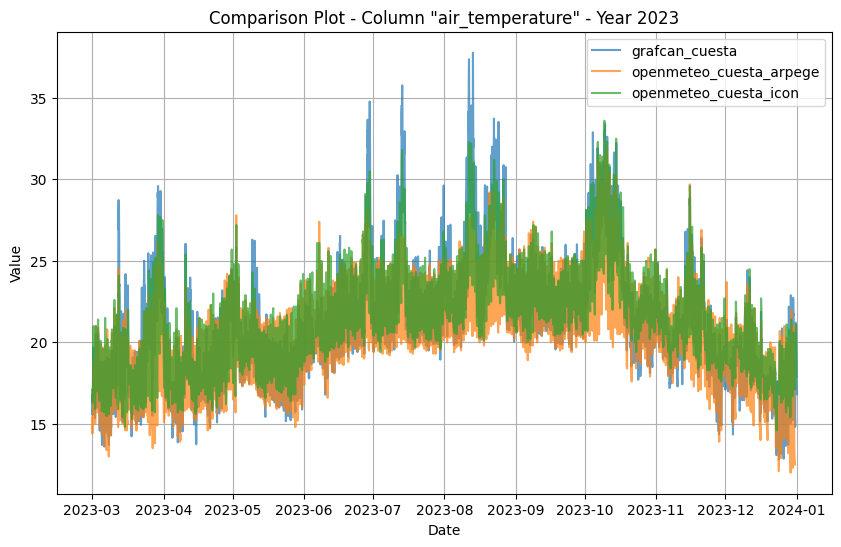

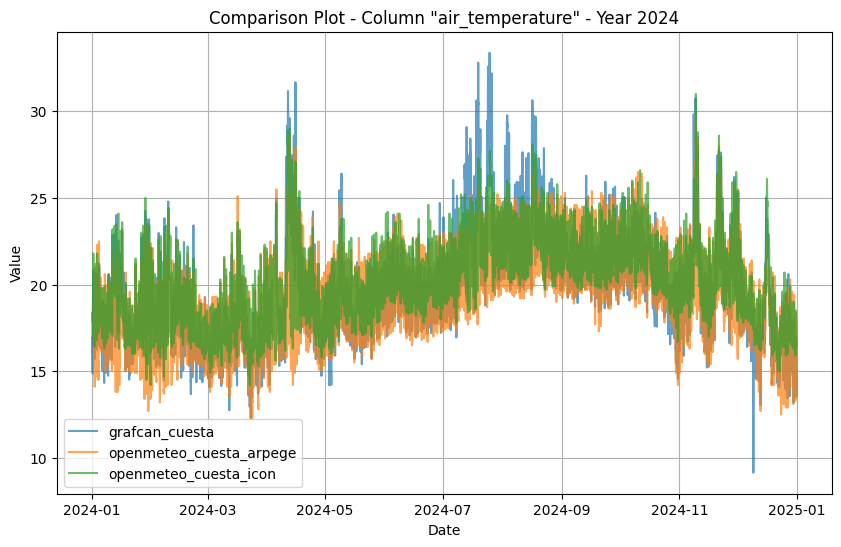

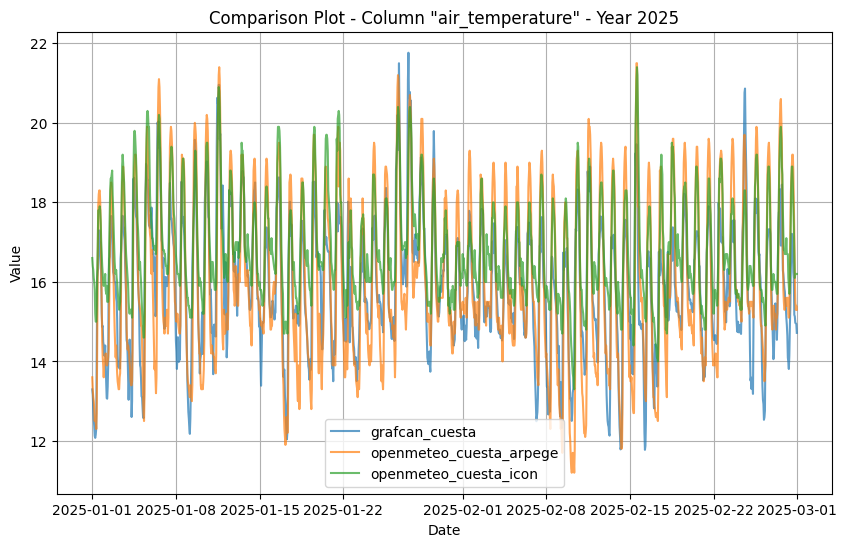

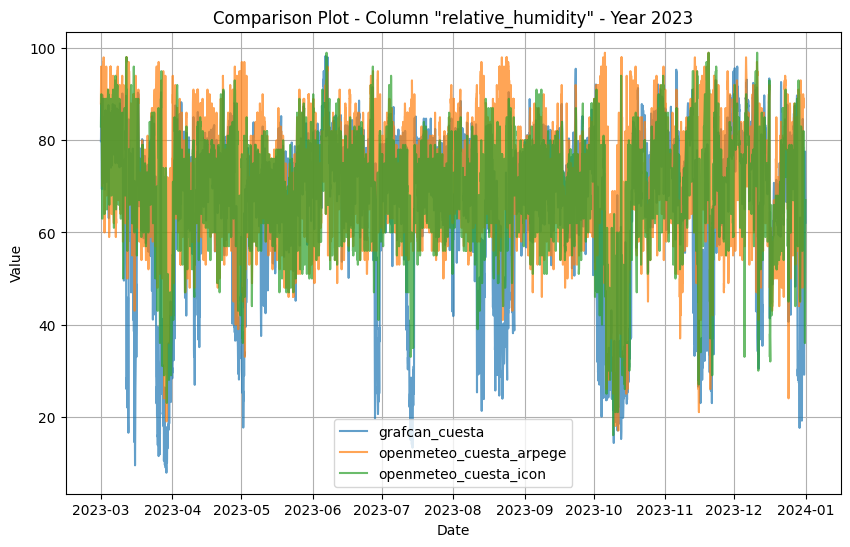

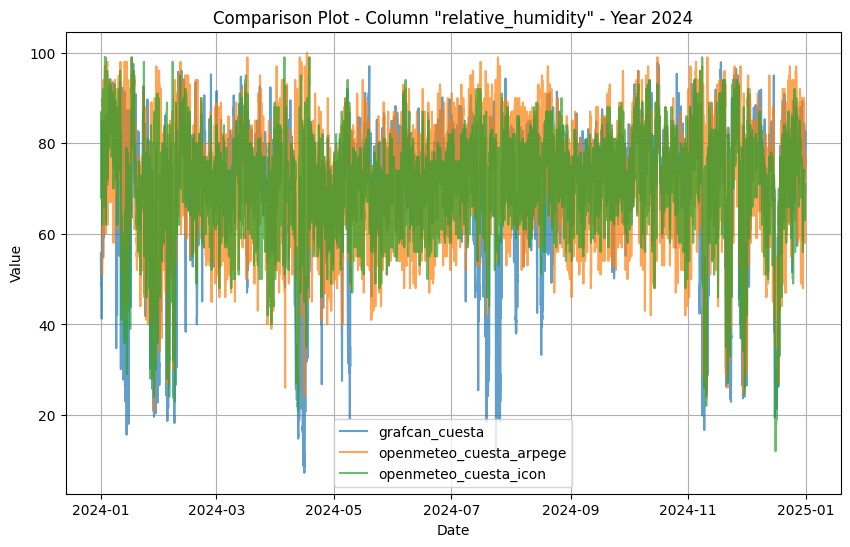

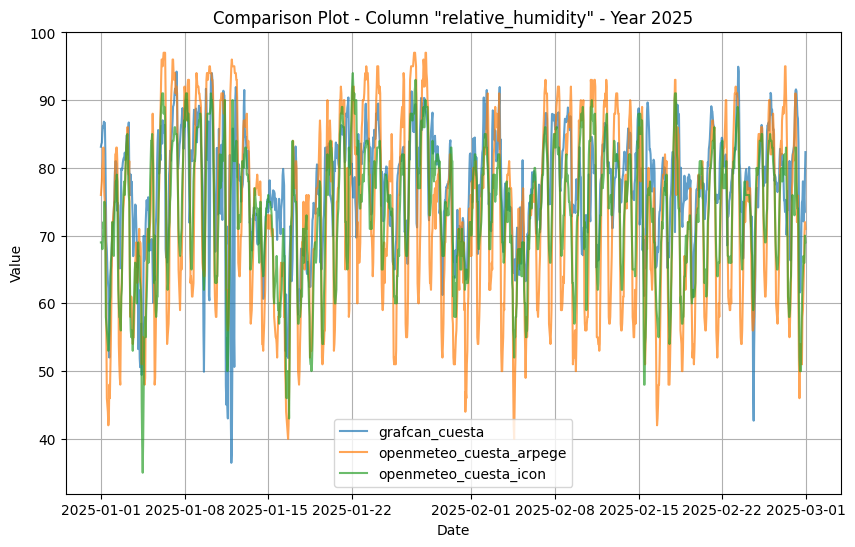

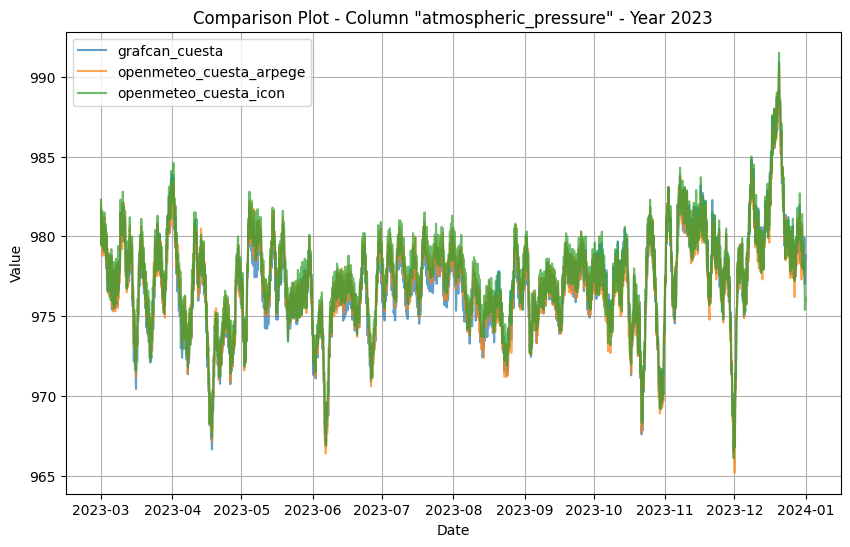

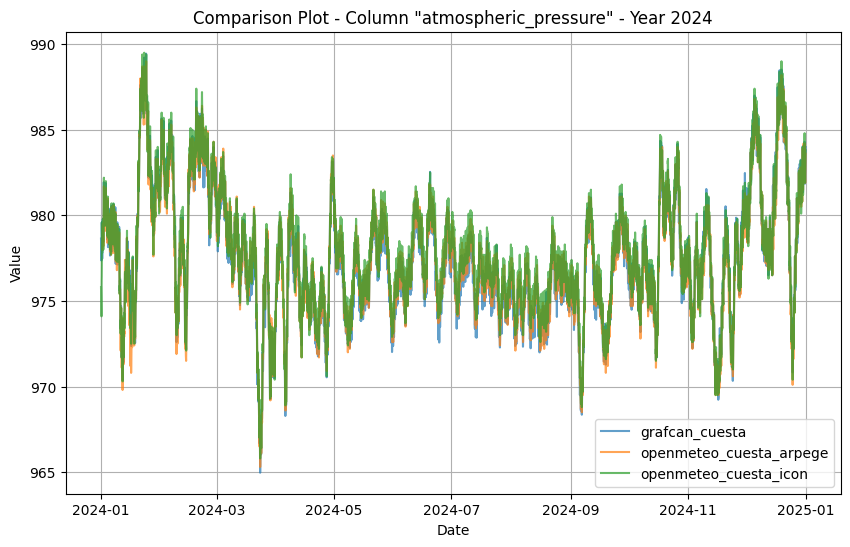

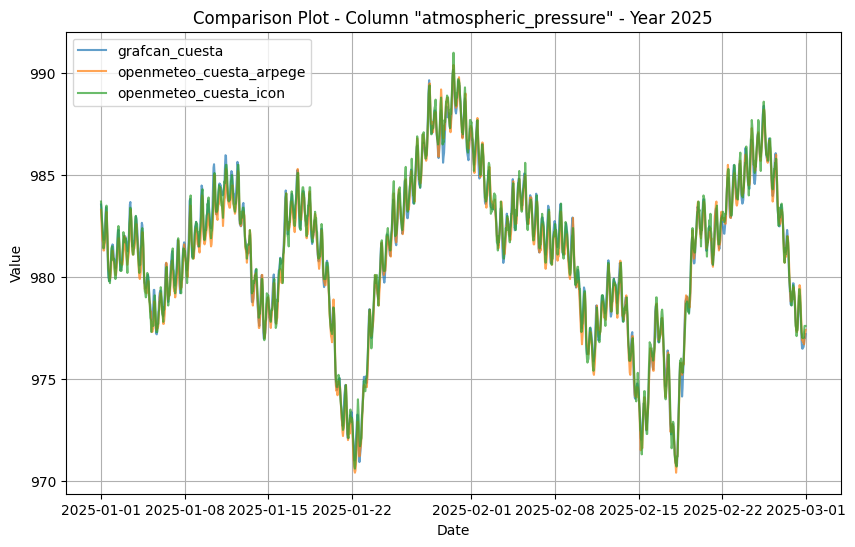

In [35]:
plot_datasets([cuesta_grafcan, cuesta_openmetoe_arpege, cuesta_openmetoe_icon], "air_temperature")
plot_datasets([cuesta_grafcan, cuesta_openmetoe_arpege, cuesta_openmetoe_icon], "relative_humidity")
plot_datasets([cuesta_grafcan, cuesta_openmetoe_arpege, cuesta_openmetoe_icon], "atmospheric_pressure")

## Horas faltantes

In [36]:
for file_key, df_hourly in dataframes.items():
    # Check for missing hours in the time series
    # Detect missing hours after resampling
    missing_hours = df_hourly[df_hourly.isna().any(axis=1)].index

    # Print missing hours if any
    if len(missing_hours) > 0:
        print(f"Missing hours in {file_key} after resampling:")
        print(missing_hours.tolist())
        print(len(missing_hours))
    else:
        print(f"No missing hours in {file_key} after resampling.")

Missing hours in openmeteo_cuesta_arpege after resampling:
[Timestamp('2023-12-31 07:00:00+0000', tz='UTC'), Timestamp('2023-12-31 08:00:00+0000', tz='UTC'), Timestamp('2023-12-31 09:00:00+0000', tz='UTC'), Timestamp('2023-12-31 10:00:00+0000', tz='UTC'), Timestamp('2023-12-31 11:00:00+0000', tz='UTC'), Timestamp('2023-12-31 12:00:00+0000', tz='UTC'), Timestamp('2023-12-31 13:00:00+0000', tz='UTC'), Timestamp('2023-12-31 14:00:00+0000', tz='UTC'), Timestamp('2023-12-31 15:00:00+0000', tz='UTC'), Timestamp('2023-12-31 16:00:00+0000', tz='UTC'), Timestamp('2023-12-31 17:00:00+0000', tz='UTC'), Timestamp('2023-12-31 18:00:00+0000', tz='UTC'), Timestamp('2023-12-31 19:00:00+0000', tz='UTC'), Timestamp('2023-12-31 20:00:00+0000', tz='UTC'), Timestamp('2023-12-31 21:00:00+0000', tz='UTC'), Timestamp('2023-12-31 22:00:00+0000', tz='UTC'), Timestamp('2023-12-31 23:00:00+0000', tz='UTC'), Timestamp('2024-01-01 00:00:00+0000', tz='UTC'), Timestamp('2024-01-01 01:00:00+0000', tz='UTC'), Timestamp

### Manejo Horas faltantes

In [37]:
# Cubic Spline Interpolation Algorithm

def pchip_interpolation(df):
 # Convert datetime index to a numeric format (Unix timestamp in seconds)
    numeric_index = df.index.astype(np.int64) // 10**9

    # Iterate over each feature column and apply cubic spline interpolation
    for col in df.columns:
        valid_mask = ~df[col].isna()
        # Check if there are enough valid points for interpolation
        if valid_mask.sum() >= 2:

            pchip = PchipInterpolator(numeric_index[valid_mask], df.loc[valid_mask, col])
            interpolated_values = pchip(numeric_index)

            #cs = CubicSpline(numeric_index[valid_mask], df.loc[valid_mask, col], bc_type='natural')
            #interpolated_values = cs(numeric_index)
            df[col] = df[col].fillna(pd.Series(interpolated_values, index=df.index))
        else:
            print(f"Not enough data points to interpolate column '{col}'.")
            
    return df

In [38]:
for file_key, df_hourly in dataframes.items():
    # Perform cubic spline interpolation on the dataframe
     pchip_interpolation(df_hourly)

In [39]:
dataframes["grafcan_cuesta"].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2023-03-01 00:00:00+00:00 to 2025-02-28 23:00:00+00:00
Freq: h
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   air_temperature       17544 non-null  float64
 1   atmospheric_pressure  17544 non-null  float64
 2   relative_humidity     17544 non-null  float64
dtypes: float64(3)
memory usage: 548.2 KB


## Comparativa datasets predicciones

In [40]:
def datasets_similarity(file1, file2):
    # Remove .csv extension if present
    file1 = file1.replace(".csv", "")
    file2 = file2.replace(".csv", "")
    
    # Ensure datasets are loaded
    if file1 not in dataframes or file2 not in dataframes:
        print("One or both datasets are not loaded.")
        return
    
    # Retrieve dataframes and align by timestamp
    df1 = dataframes[file1]
    df2 = dataframes[file2]
    df1, df2 = df1.align(df2, join='inner')
    
    similarity_results = {}
    for column in df1.columns:
        if column in df2.columns:
            try:
                pearson_corr, _ = pearsonr(df1[column], df2[column])
                spearman_corr, _ = spearmanr(df1[column], df2[column])
                kendall_corr, _ = kendalltau(df1[column], df2[column])
                mse = mean_squared_error(df1[column], df2[column])
                euclid_dist = euclidean(df1[column], df2[column])
                
                similarity_results[column] = {
                    "Pearson": pearson_corr,
                    "Spearman": spearman_corr,
                    "Kendall": kendall_corr,
                    "MSE": mse,
                    "Euclidean Distance": euclid_dist
                }
            except Exception as e:
                print(f"Error calculating similarity for {column}: {e}")
    
    print(f"Similarity Metrics for {file1} vs {file2}")
    for col, metrics in similarity_results.items():
        print(f"  {col}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.4f}")


In [41]:
datasets_similarity(cuesta_openmetoe_icon, cuesta_grafcan)

Similarity Metrics for openmeteo_cuesta_icon vs grafcan_cuesta
  air_temperature:
    Pearson: 0.9010
    Spearman: 0.9113
    Kendall: 0.7608
    MSE: 2.6367
    Euclidean Distance: 215.0776
  atmospheric_pressure:
    Pearson: 0.9880
    Spearman: 0.9828
    Kendall: 0.8969
    MSE: 0.4902
    Euclidean Distance: 92.7397
  relative_humidity:
    Pearson: 0.5327
    Spearman: 0.5751
    Kendall: 0.4349
    MSE: 205.6620
    Euclidean Distance: 1899.5088


In [42]:
datasets_similarity(cuesta_openmetoe_arpege, cuesta_grafcan)

Similarity Metrics for openmeteo_cuesta_arpege vs grafcan_cuesta
  air_temperature:
    Pearson: 0.8372
    Spearman: 0.8697
    Kendall: 0.7077
    MSE: 4.3515
    Euclidean Distance: 276.3019
  atmospheric_pressure:
    Pearson: 0.9887
    Spearman: 0.9845
    Kendall: 0.9019
    MSE: 0.2917
    Euclidean Distance: 71.5328
  relative_humidity:
    Pearson: 0.3249
    Spearman: 0.4390
    Kendall: 0.3381
    MSE: 317.8278
    Euclidean Distance: 2361.3494


## Detección de outliers



In [43]:
def detect_outliers_iqr(df, threshold=1.5, return_indices=False):
    """
    Detects and plots outliers in each numerical column of a Pandas DataFrame using the Interquartile Range (IQR) method.
    Optionally returns indices of the detected outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): The multiplier for the IQR to determine outlier boundaries.
        return_indices (bool): If True, also return a dictionary of outlier indices for each column.
        
    Returns:
        outliers_dict (dict): A dictionary containing outlier values for each numerical column.
        outlier_indices_dict (dict, optional): A dictionary containing outlier row indices for each numerical column.
    """
    outliers_dict = {}
    outlier_indices_dict = {}
    
    for column in df.select_dtypes(include=[np.number]).columns:
        # Calculate IQR-based bounds
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = outliers.tolist()
        outlier_indices_dict[column] = outliers.index.tolist()
        
        # Create subplots for boxplot and histogram
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        
        # Boxplot on the left with outliers highlighted
        ax1.boxplot(df[column], vert=False)
        ax1.scatter(outliers, [1] * len(outliers), color='red', label='Outliers')
        ax1.set_title(f'Boxplot of {column}')  # Fixed typo here
        ax1.set_xlabel(column)
        ax1.legend()
        
        # Histogram on the right with bounds indicated
        ax2.hist(df[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        ax2.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1, label='Lower bound')
        ax2.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1, label='Upper bound')
        ax2.set_title(f'Histogram of {column}')
        ax2.set_xlabel(column)
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    if return_indices:
        return outliers_dict, outlier_indices_dict
    return outliers_dict


Processing openmeteo_cuesta_arpege:


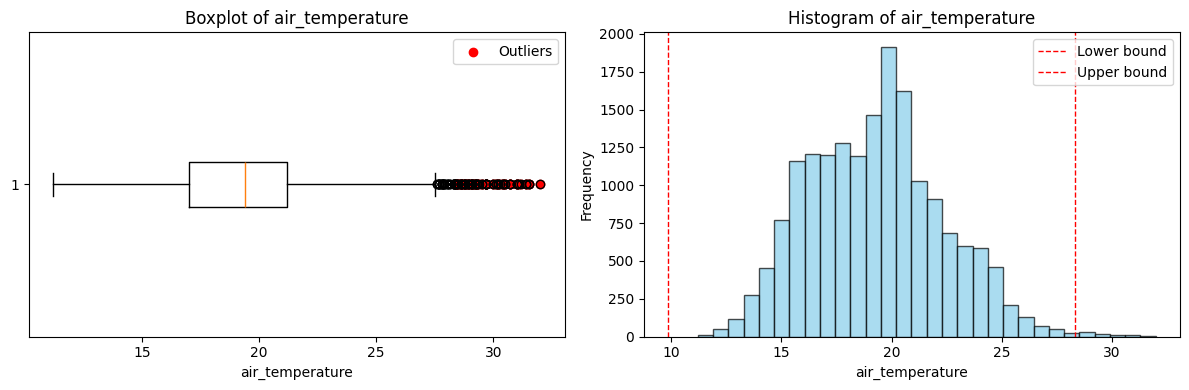

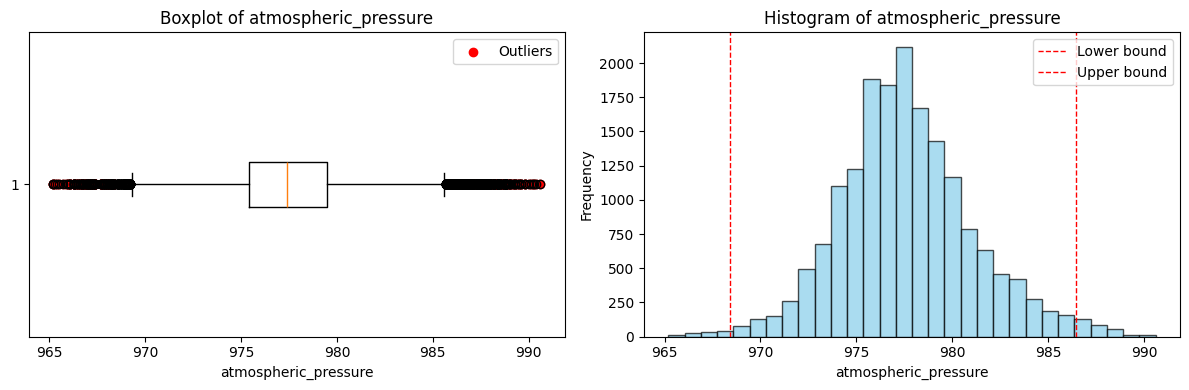

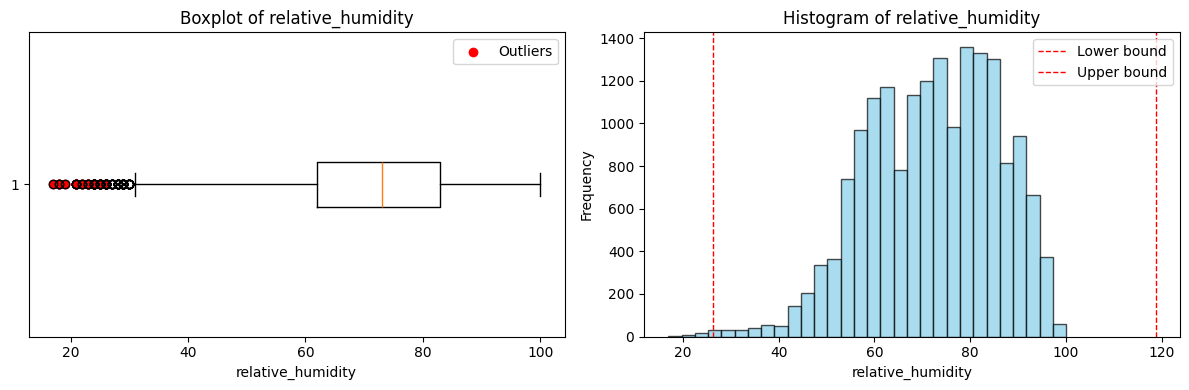

  air_temperature outlier row indices: [Timestamp('2023-08-20 13:00:00+0000', tz='UTC'), Timestamp('2023-08-20 14:00:00+0000', tz='UTC'), Timestamp('2023-08-22 13:00:00+0000', tz='UTC'), Timestamp('2023-08-22 14:00:00+0000', tz='UTC'), Timestamp('2023-08-22 15:00:00+0000', tz='UTC'), Timestamp('2023-08-22 16:00:00+0000', tz='UTC'), Timestamp('2023-08-25 13:00:00+0000', tz='UTC'), Timestamp('2023-08-26 16:00:00+0000', tz='UTC'), Timestamp('2023-08-26 17:00:00+0000', tz='UTC'), Timestamp('2023-10-06 12:00:00+0000', tz='UTC'), Timestamp('2023-10-06 13:00:00+0000', tz='UTC'), Timestamp('2023-10-06 14:00:00+0000', tz='UTC'), Timestamp('2023-10-06 15:00:00+0000', tz='UTC'), Timestamp('2023-10-06 16:00:00+0000', tz='UTC'), Timestamp('2023-10-06 17:00:00+0000', tz='UTC'), Timestamp('2023-10-07 11:00:00+0000', tz='UTC'), Timestamp('2023-10-07 12:00:00+0000', tz='UTC'), Timestamp('2023-10-07 13:00:00+0000', tz='UTC'), Timestamp('2023-10-07 14:00:00+0000', tz='UTC'), Timestamp('2023-10-07 15:00:0

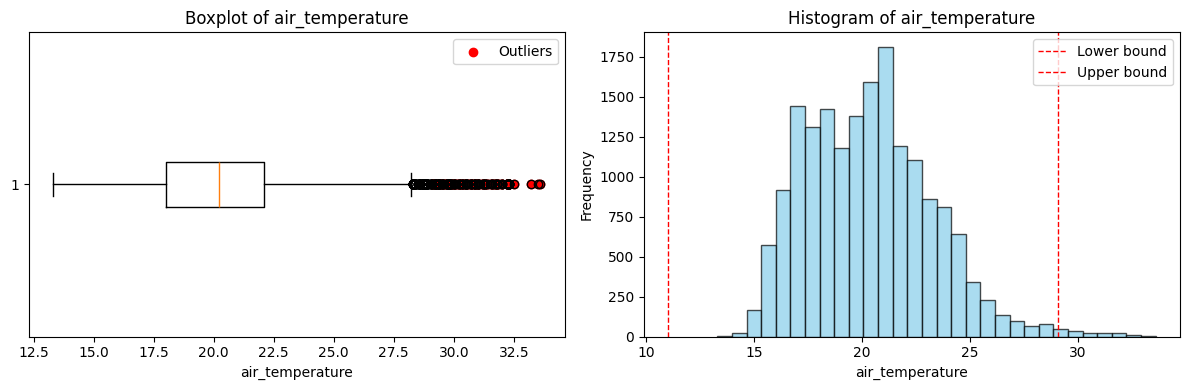

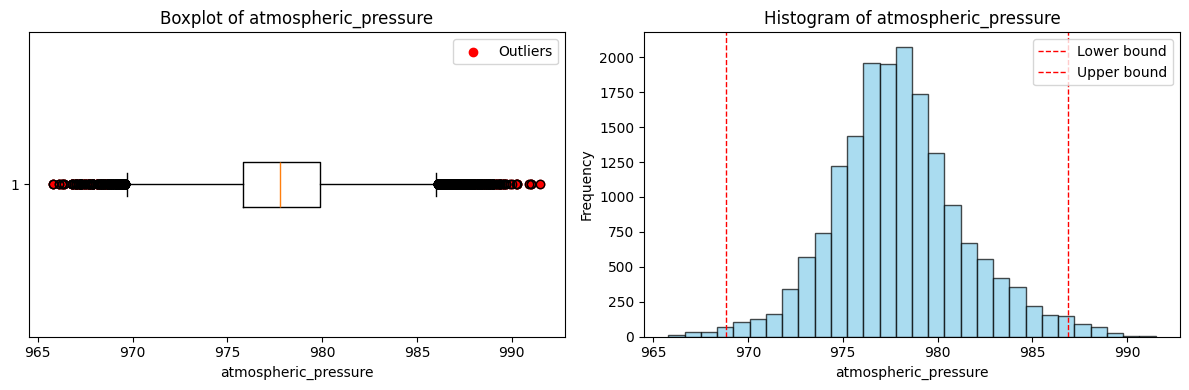

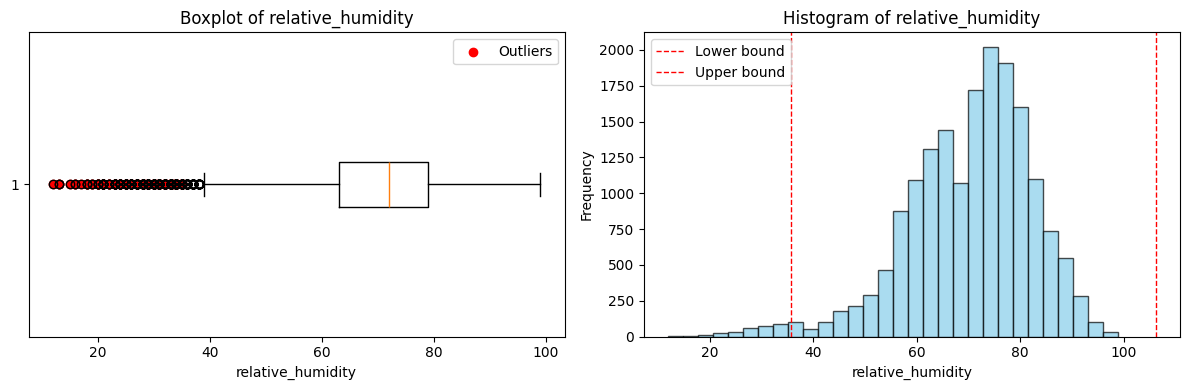

  air_temperature outlier row indices: [Timestamp('2023-06-27 15:00:00+0000', tz='UTC'), Timestamp('2023-06-28 12:00:00+0000', tz='UTC'), Timestamp('2023-06-28 13:00:00+0000', tz='UTC'), Timestamp('2023-06-28 14:00:00+0000', tz='UTC'), Timestamp('2023-06-28 15:00:00+0000', tz='UTC'), Timestamp('2023-06-28 16:00:00+0000', tz='UTC'), Timestamp('2023-06-29 12:00:00+0000', tz='UTC'), Timestamp('2023-06-29 13:00:00+0000', tz='UTC'), Timestamp('2023-06-29 14:00:00+0000', tz='UTC'), Timestamp('2023-06-29 15:00:00+0000', tz='UTC'), Timestamp('2023-06-29 16:00:00+0000', tz='UTC'), Timestamp('2023-07-13 11:00:00+0000', tz='UTC'), Timestamp('2023-07-13 12:00:00+0000', tz='UTC'), Timestamp('2023-07-13 13:00:00+0000', tz='UTC'), Timestamp('2023-07-13 14:00:00+0000', tz='UTC'), Timestamp('2023-07-13 15:00:00+0000', tz='UTC'), Timestamp('2023-07-13 16:00:00+0000', tz='UTC'), Timestamp('2023-07-13 17:00:00+0000', tz='UTC'), Timestamp('2023-07-13 18:00:00+0000', tz='UTC'), Timestamp('2023-07-14 13:00:0

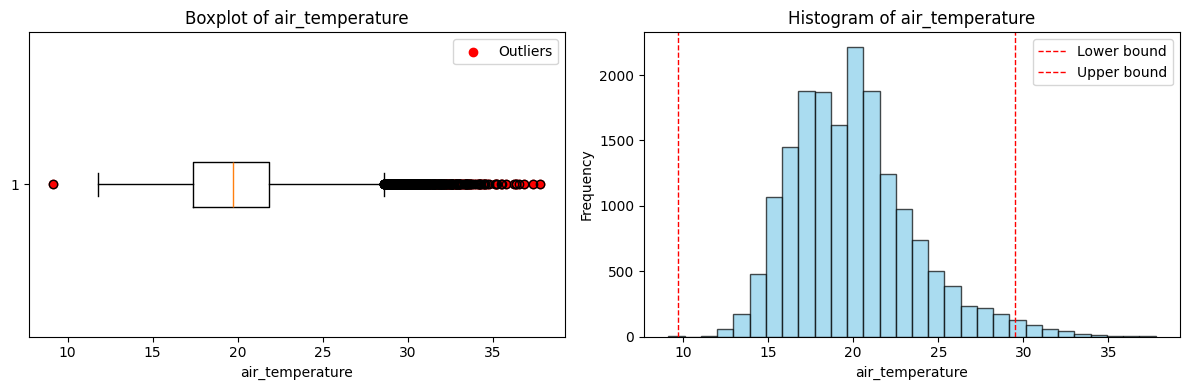

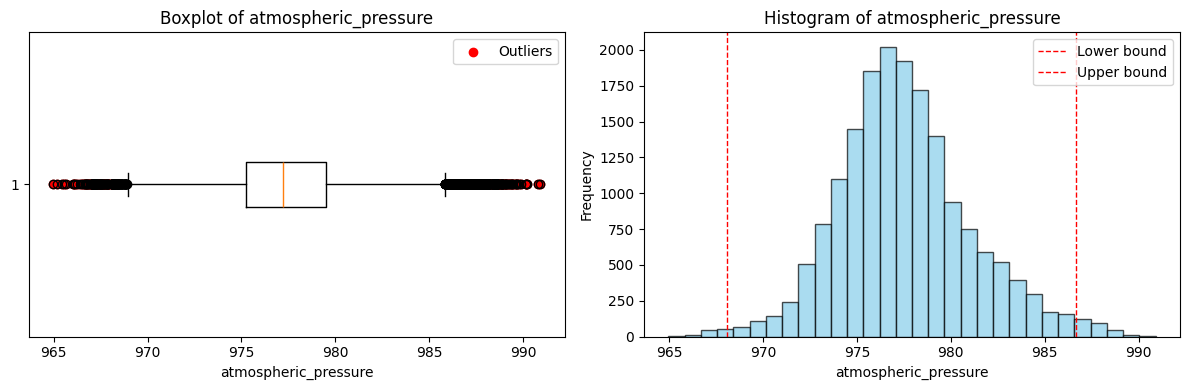

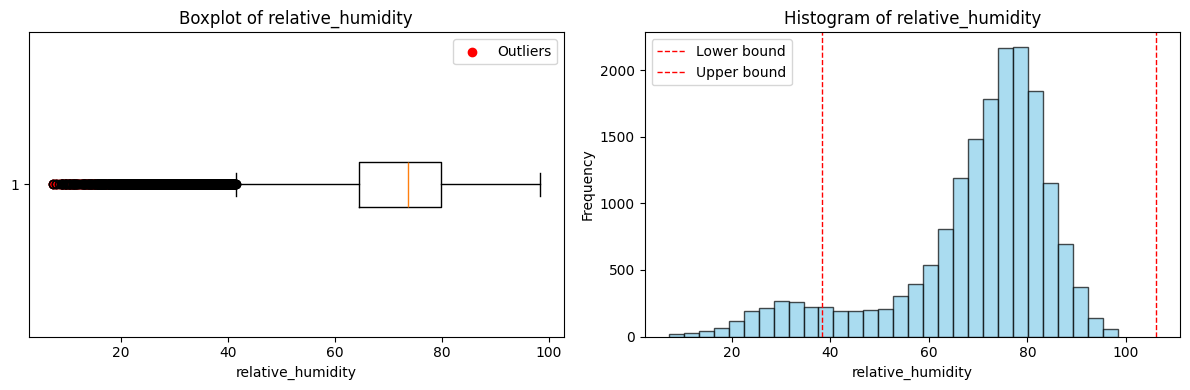

  air_temperature outlier row indices: [Timestamp('2023-03-29 14:00:00+0000', tz='UTC'), Timestamp('2023-03-29 15:00:00+0000', tz='UTC'), Timestamp('2023-06-28 10:00:00+0000', tz='UTC'), Timestamp('2023-06-28 11:00:00+0000', tz='UTC'), Timestamp('2023-06-28 12:00:00+0000', tz='UTC'), Timestamp('2023-06-28 13:00:00+0000', tz='UTC'), Timestamp('2023-06-28 14:00:00+0000', tz='UTC'), Timestamp('2023-06-28 15:00:00+0000', tz='UTC'), Timestamp('2023-06-28 16:00:00+0000', tz='UTC'), Timestamp('2023-06-28 17:00:00+0000', tz='UTC'), Timestamp('2023-06-28 18:00:00+0000', tz='UTC'), Timestamp('2023-06-28 19:00:00+0000', tz='UTC'), Timestamp('2023-06-28 20:00:00+0000', tz='UTC'), Timestamp('2023-06-28 21:00:00+0000', tz='UTC'), Timestamp('2023-06-28 22:00:00+0000', tz='UTC'), Timestamp('2023-06-29 08:00:00+0000', tz='UTC'), Timestamp('2023-06-29 09:00:00+0000', tz='UTC'), Timestamp('2023-06-29 10:00:00+0000', tz='UTC'), Timestamp('2023-06-29 11:00:00+0000', tz='UTC'), Timestamp('2023-06-29 12:00:0

In [44]:
threshold = 1.7

for file_key, df_hourly in dataframes.items():
    print(f"Processing {file_key}:")
    
    # Use the modified function to get both outlier values and their indices
    outliers, outlier_indices = detect_outliers_iqr(df_hourly, threshold, return_indices=True)
    
    # Print outliers for each column
    for column, indices in outlier_indices.items():
        print(f"  {column} outlier row indices: {indices}")
    
    # Combine all outlier indices from every column
    all_outlier_indices = set()
    for indices in outlier_indices.values():
        all_outlier_indices.update(indices)
    
    # Remove rows with any detected outlier
    # df_clean = df_hourly.drop(list(all_outlier_indices))
    # dataframes[file_key] = df_clean
    
    print(f"Removed {len(all_outlier_indices)} rows with outliers from {file_key}.\n")

## Exploración frecuencias - Fourier

In [45]:
def plot_frequencies(df, column, freq_min, freq_max, top_n=3, sampling_interval=3600):
    values = df[column].values  # Extraer la columna de valores
    
    fft_result = np.fft.fft(values)  # Calcular la FFT
    frequencies = np.fft.fftfreq(len(values), d=sampling_interval)  # Calcular las frecuencias
    
    # Solo conservar las frecuencias positivas
    positive_frequencies = frequencies[:len(values) // 2]
    positive_fft_result = fft_result[:len(values) // 2]
    magnitude = np.abs(positive_fft_result)
    
    # Filtrar las frecuencias dentro del rango deseado
    mask = (positive_frequencies >= freq_min) & (positive_frequencies <= freq_max)
    filtered_frequencies = positive_frequencies[mask]
    filtered_magnitude = magnitude[mask]
    
    # Encontrar los índices de las N frecuencias con mayor magnitud
    top_indices = np.argsort(filtered_magnitude)[-top_n:]
    
    # Imprimir las N frecuencias principales
    print(f"Top {top_n} frequencies with highest magnitude:")
    for idx in top_indices:
        frequency_hz = filtered_frequencies[idx]
        period_hours = 1 / (frequency_hz * 3600)
        print(f"Frequency: {frequency_hz:.8f} Hz, Period: {period_hours:.2f} hours, Magnitude: {filtered_magnitude[idx]:.4f}")
    
    # Graficar el espectro de frecuencia con escala logarítmica en el eje X
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_frequencies, filtered_magnitude, label='Frequency Spectrum')
    
    # Resaltar las N frecuencias principales
    top_frequencies = filtered_frequencies[top_indices]
    top_magnitudes = filtered_magnitude[top_indices]
    plt.scatter(top_frequencies, top_magnitudes, color='red', zorder=5, label=f'Top {top_n} Frequencies')
    
    # Configurar escala logarítmica para el eje X
    plt.xscale('log')
    plt.xlabel('Frequency (Hz, log scale)')
    plt.ylabel('Magnitude')
    plt.title(f'Frequency Spectrum between {freq_min} Hz and {freq_max} Hz')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2023-03-01 00:00:00+00:00 to 2025-02-28 23:00:00+00:00
Freq: h
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   air_temperature       17544 non-null  float64
 1   atmospheric_pressure  17544 non-null  float64
 2   relative_humidity     17544 non-null  float64
dtypes: float64(3)
memory usage: 548.2 KB
Top 5 frequencies with highest magnitude:
Frequency: 0.00000024 Hz, Period: 1169.60 hours, Magnitude: 6114.8545
Frequency: 0.00000011 Hz, Period: 2506.29 hours, Magnitude: 6306.0925
Frequency: 0.00000002 Hz, Period: 17544.00 hours, Magnitude: 7857.5862
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 16591.9227
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 27621.5186


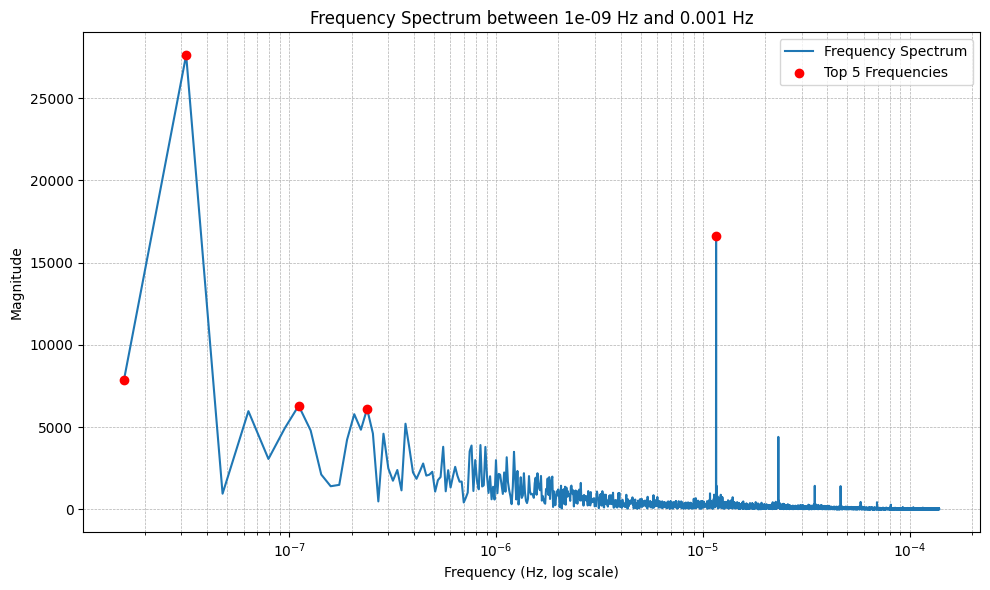

Top 5 frequencies with highest magnitude:
Frequency: 0.00000030 Hz, Period: 923.37 hours, Magnitude: 31050.4880
Frequency: 0.00000011 Hz, Period: 2506.29 hours, Magnitude: 31767.6582
Frequency: 0.00000002 Hz, Period: 17544.00 hours, Magnitude: 31958.7750
Frequency: 0.00000024 Hz, Period: 1169.60 hours, Magnitude: 39646.5803
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 40474.5705


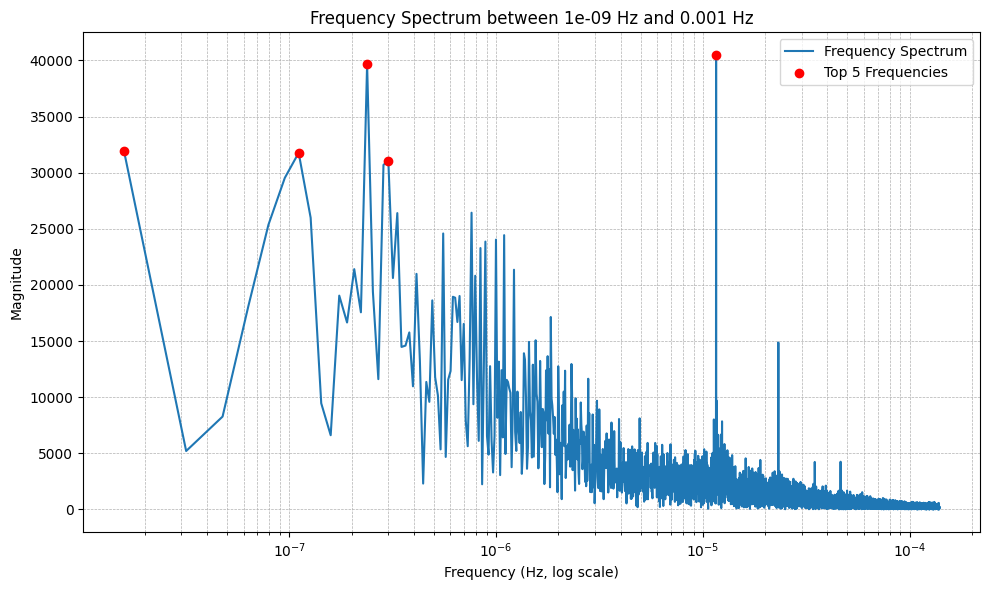

Top 5 frequencies with highest magnitude:
Frequency: 0.00000016 Hz, Period: 1754.40 hours, Magnitude: 6717.8432
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 7537.5908
Frequency: 0.00000032 Hz, Period: 877.20 hours, Magnitude: 7985.1119
Frequency: 0.00000006 Hz, Period: 4386.00 hours, Magnitude: 11432.8576
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 20171.5875


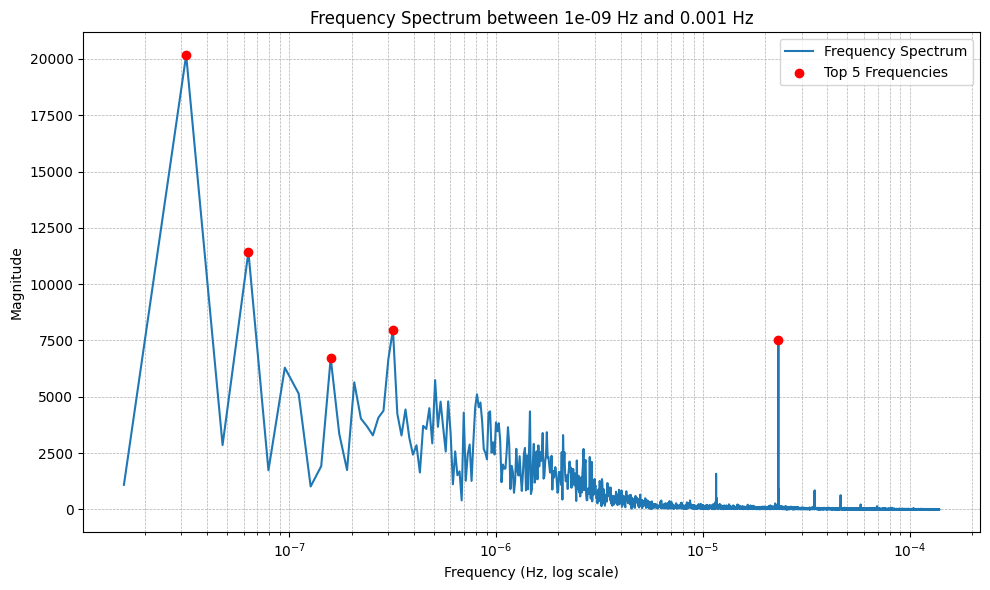

In [46]:
min_frequency = 10**-9
max_frequency = 10**-3
top_n = 5

dataframes["grafcan_cuesta"].info()

plot_frequencies(dataframes["grafcan_cuesta"], "air_temperature", min_frequency, max_frequency, top_n)
plot_frequencies(dataframes["grafcan_cuesta"], "relative_humidity", min_frequency, max_frequency, top_n)
plot_frequencies(dataframes["grafcan_cuesta"], "atmospheric_pressure", min_frequency, max_frequency, top_n)



## Adición datos temporales

In [47]:
# Extract hour and minute to get a more continuous representation of time within a day
df = dataframes["grafcan_cuesta"].copy()
df.index.name = "time"
df.reset_index(inplace=True)

df['time'] = pd.to_datetime(df['time'])
hours = df['time'].dt.hour
minutes  = df['time'].dt.minute
hour_fraction = hours + minutes / 60.0

# Convert the hour fraction into sine and cosine features to capture cyclical patterns (period = 24 hours)
df['sin_day'] = np.sin(2 * np.pi * hour_fraction / 24)
df['cos_day'] = np.cos(2 * np.pi * hour_fraction / 24)

# Extract day of the week (0 = Monday, 6 = Sunday)
day_of_week = df['time'].dt.weekday

# Compute the continuous week fraction (e.g., Monday at noon = 0.5, Sunday at 23:59 = 6.999)
week_fraction = day_of_week + hour_fraction / 24.0  # Continuous representation of the week

# Encode the continuous week representation using sine and cosine (for weekly cycle, period = 7 days)
df['sin_week'] = np.sin(2 * np.pi * week_fraction / 7)
df['cos_week'] = np.cos(2 * np.pi * week_fraction / 7)

# For annual features: extract the day of the year (1-366)
day_of_year = df['time'].dt.dayofyear

# Create a continuous representation of the year:
# Subtracting 1 from day_of_year makes it start at 0, then add the fractional day.
year_fraction = (day_of_year - 1) + hour_fraction / 24.0

# Convert the continuous year representation into sine and cosine features (assuming period = 365 days)
df['sin_year'] = np.sin(2 * np.pi * year_fraction / 365)
df['cos_year'] = np.cos(2 * np.pi * year_fraction / 365)

# Remove original time variable
#df.drop(columns="time", inplace=True)


                          time  air_temperature  atmospheric_pressure  \
time                  1.000000        -0.224509              0.216341   
air_temperature      -0.224509         1.000000             -0.235657   
atmospheric_pressure  0.216341        -0.235657              1.000000   
relative_humidity     0.184297        -0.590118             -0.048027   
sin_day              -0.001061        -0.214555              0.010168   
cos_day              -0.000140        -0.303802             -0.034269   
sin_week              0.001640        -0.002256              0.018002   
cos_week              0.000031        -0.024432             -0.018119   
sin_year             -0.204902        -0.466320              0.080398   
cos_year              0.333351        -0.407199              0.448393   

                      relative_humidity       sin_day       cos_day  sin_week  \
time                           0.184297 -1.060518e-03 -1.396198e-04  0.001640   
air_temperature               -0.5

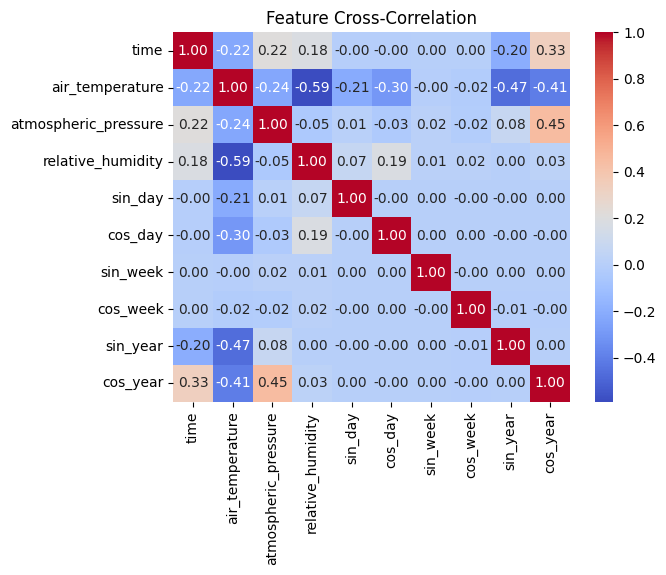

In [48]:
import seaborn as sns
# Compute correlation matrix
correlation_matrix = df.corr()

# Print correlation values
print(correlation_matrix)

# Heatmap for visualization
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Cross-Correlation")
plt.show()


In [49]:
df.drop(columns=["sin_week", "cos_week"], inplace=True)

## ARIMA

                               SARIMAX Results                                
Dep. Variable:        air_temperature   No. Observations:                17544
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -16916.437
Date:                Mon, 31 Mar 2025   AIC                          33844.874
Time:                        00:44:26   BIC                          33891.508
Sample:                             0   HQIC                         33860.229
                              - 17544                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4056      0.003    124.085      0.000       0.399       0.412
ar.L2          0.0164      0.005      3.234      0.001       0.006       0.026
ar.L3          0.0042      0.006      0.681      0.4

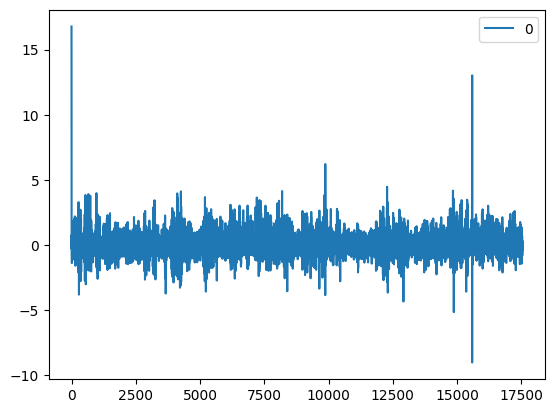

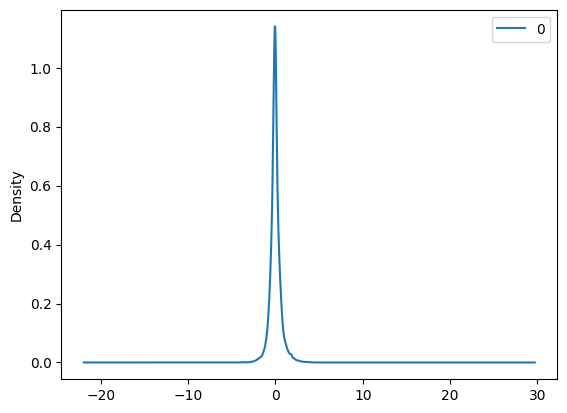

                  0
count  17544.000000
mean       0.000880
std        0.647187
min       -9.025199
25%       -0.274229
50%       -0.035971
75%        0.235762
max       16.781813


In [91]:
model_temp = ARIMA(df["air_temperature"], order=(5,1,0))
model_fit = model_temp.fit()

# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [ ]:
target_day = '2025-01-01'
indices = df[df['time'].dt.date == pd.to_datetime(target_day).date()].index
first_2025_day_index = indices[0]

train = df.iloc[0:first_2025_day_index]["air_temperature"]
test = df.iloc[first_2025_day_index:]["air_temperature"]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test.iloc[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

16128    13.296237
16129    13.161880
16130    12.874572
16131    12.535737
16132    12.377865
           ...    
17539    15.131597
17540    14.969768
17541    14.955097
17542    14.944347
17543    14.717612
Name: air_temperature, Length: 1416, dtype: float64
predicted=13.255869, expected=13.296237
predicted=13.172614, expected=13.161880
predicted=13.114318, expected=12.874572
predicted=12.782433, expected=12.535737
predicted=12.424250, expected=12.377865
predicted=12.317115, expected=12.123875
predicted=12.022664, expected=12.076372
predicted=12.061086, expected=12.158708


## LSTM

### Dataset básico

In [50]:
import keras
import tensorflow as tf


# Test/Train split #
####################
target_day = '2025-01-01'

indices = df[df['time'].dt.date == pd.to_datetime(target_day).date()].index
first_2025_day_index = indices[0]
print(df.iloc[first_2025_day_index])

###################################################
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return [(data - data_mean) / data_std, data_mean, data_std]
#################################################

features = df.drop(columns=["time", "sin_day", "cos_day", "sin_year", "cos_year"])
normalized_features, mean, std = normalize(features.values, first_2025_day_index)
normalized_features = pd.DataFrame(normalized_features, columns=features.columns)
normalized_features["sin_day"] = df["sin_day"]
normalized_features["cos_day"] = df["cos_day"]
normalized_features["sin_year"] = df["sin_year"]
normalized_features["cos_year"] = df["cos_year"]
print("Normalized: ", normalized_features.head())

train_data = normalized_features.loc[0 : first_2025_day_index]
val_data = normalized_features.loc[first_2025_day_index:]

# Training data structure #
###########################
past = 30
HOURS_TO_FORECAST = 3
future = HOURS_TO_FORECAST

# Labels start after past data
label_start = past
label_end = label_start + first_2025_day_index

x_train = train_data
# y_train = normalized_features.iloc[label_start:label_end]
y_train = normalized_features.iloc[label_start:label_end].drop(columns=["sin_day", "cos_day", "sin_year", "cos_year"])
y_train_multi = np.array([y_train[i:i+future] for i in range(len(y_train) - future + 1)])

# Validation data structure #
#############################
x_val_end = len(val_data) - past - future
val_label_start = first_2025_day_index + past

x_val = val_data.iloc[:x_val_end]
# y_val = normalized_features.iloc[val_label_start:]
y_val = normalized_features.iloc[val_label_start:].drop(columns=["sin_day", "cos_day", "sin_year", "cos_year"])
y_val_multi = np.array([y_val[i:i+future] for i in range(len(y_val) - future + 1)])

# Parameters #
##############
batch_size =128
step = 1 

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train_multi,
    sequence_length=past,
    sampling_rate=step,
    batch_size=batch_size,
)

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val_multi,
    sequence_length=past,
    sampling_rate=step,
    batch_size=batch_size,
)

tf.data.Dataset.save(dataset_train, "dataset_train_cuesta")
tf.data.Dataset.save(dataset_val, "dataset_val_cuesta")


for batch_x, batch_y in dataset_train.take(1):  # Take the first batch
    print("First batch X:", batch_x.numpy())
    print("First batch Y:", batch_y.numpy())



time                    2025-01-01 00:00:00+00:00
air_temperature                         13.296237
atmospheric_pressure                   983.553589
relative_humidity                        83.11875
sin_day                                       0.0
cos_day                                       1.0
sin_year                                      0.0
cos_year                                      1.0
Name: 16128, dtype: object
Normalized:     air_temperature  atmospheric_pressure  relative_humidity   sin_day  \
0        -1.018304              1.333988           0.670254  0.000000   
1        -1.062528              1.216460           0.716861  0.258819   
2        -1.149606              1.090947           1.053583  0.500000   
3        -1.249923              0.887426           1.078570  0.707107   
4        -1.374478              0.768488           1.157604  0.866025   

    cos_day  sin_year  cos_year  
0  1.000000  0.849817  0.527078  
1  0.965926  0.850195  0.526468  
2  0.866025  0.8505

In [51]:
print("mean", mean)
print("std", std)

mean [ 20.34566582 977.21284691  68.56472396]
std [ 3.499793    3.35243743 16.77530141]


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 27)             │         3,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           252 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 3, 3)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,032 (15.75 KB)

 Trainable params: 4,032 (15.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/750
123/126 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5579
Epoch 1: val_loss improved from inf to 0.15179, saving model to model_checkpoint.weights.h5
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.5514 - val_loss: 0.1518 - learning_rate: 0.0050
Epoch 2/750
123/126 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1976
Epoch 2: val_loss improved from 0.15179 to 0.10462, saving model to model_checkpoint.weights.h5
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1965 - val_loss: 0.1046 - learning_rate: 0.0050
Epoch 3/750
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1428
Epoch 3: val_loss improved from 0.10462 to 0.09795, saving model to model_checkpoint.weights.h5
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1421 - val_loss: 0.0980 - learning_rate: 0.0050
Epoch 4/750
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1203
Epoch 4: val_loss improved from 0.09795 to 0.07784, saving model to model_checkpoint.weights.h5
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.

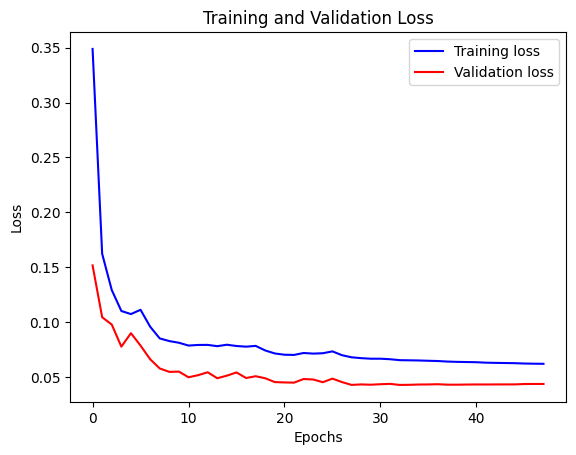

In [52]:
############
# Training #
epochs = 750
learning_rate = 0.005

dataset_train = tf.data.Dataset.load("dataset_train_cuesta")
dataset_val = tf.data.Dataset.load("dataset_val_cuesta")

for batch in dataset_train.take(1):
    inputs, targets = batch
    
#print("here?")

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(27)(inputs)
# lstm_out = keras.layers.LayerNormalization()(lstm_out) 

#lstm_out = keras.layers.Bidirectional(keras.layers.LSTM(64))(inputs)

#lstm_out = keras.layers.Bidirectional(keras.layers.LSTM(16, return_sequences=True))(inputs)
#lstm_out = keras.layers.Bidirectional(keras.layers.LSTM(16))(lstm_out)

# lstm_out = keras.layers.LSTM(256, return_sequences=True)(inputs)
# lstm_out = keras.layers.LayerNormalization()(lstm_out) 
# # lstm_out = keras.layers.LSTM(32, return_sequences=True)(lstm_out)
# lstm_out = keras.layers.LSTM(128)(lstm_out)


# Ensure the Dense layer outputs the correct shape
#lstm_out = keras.layers.Dense(16, activation='tanh')(lstm_out)
output_units = targets.shape[1] * targets.shape[2]  # Flatten output shape
outputs = keras.layers.Dense(output_units)(lstm_out)

# Reshape to match the target shape
outputs = keras.layers.Reshape((targets.shape[1], targets.shape[2]))(outputs)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

path_checkpoint = "model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=15)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

# Added reduce on plateau
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.7,         # reduce LR by a factor of 0.5
    patience=4,         # wait for 5 epochs before reducing
    verbose=1,
    min_lr=1e-7,
    min_delta=0.00001
)


history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    #callbacks=[es_callback, modelckpt_callback],
    callbacks=[es_callback, modelckpt_callback, reduce_lr_callback],
    #callbacks=[modelckpt_callback, reduce_lr_callback],
    
)

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [53]:
def mse(i):
    mse_metric = tf.keras.metrics.MeanSquaredError()

    for X_batch, Y_batch in dataset_val:
        Y_pred_batch = model(X_batch, training=False)
        # Update the metric using only the first two variables
        mse_metric.update_state(Y_batch[:,:,i], Y_pred_batch[:,:,i])

    print("MSE on variable " + str(i) + ": ", mse_metric.result().numpy())


mse(0)
mse(1)
mse(2)


MSE on variable 0:  0.033394426
MSE on variable 1:  0.010678686
MSE on variable 2:  0.087529644


Index(['air_temperature'], dtype='object')
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


IndexError: index 1 is out of bounds for axis 0 with size 1

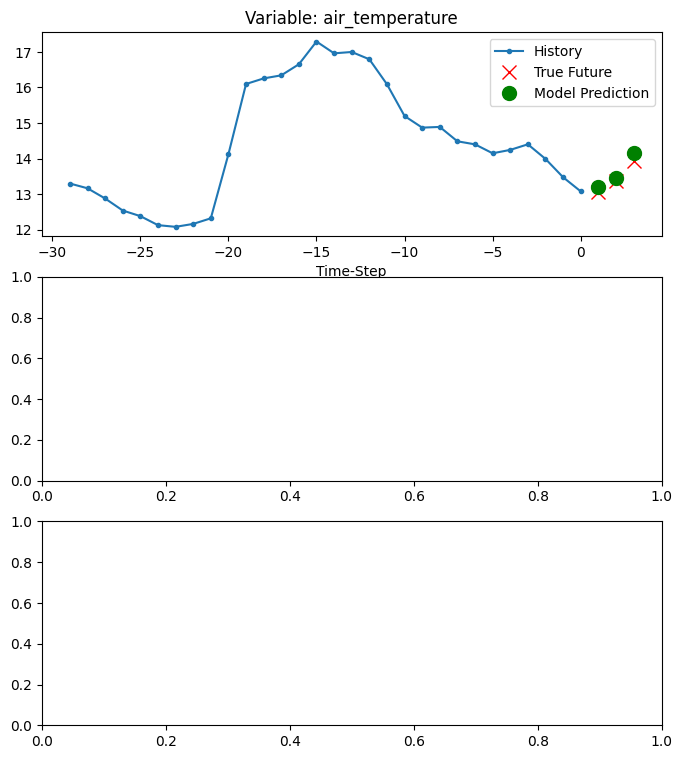

In [87]:
def show_plots_for_variables(plot_data, delta, feature_names, mean, std):
    """
    Plots separate graphs for each variable, showing the 3 forecast points in true scale.
    
    Parameters:
    - plot_data: List containing [history, true future, model prediction].
    - delta: Time step offset for forecasts.
    - feature_names: List of feature names for labeling each subplot.
    - mean: Mean values for each feature (for denormalization).
    - std: Standard deviation values for each feature (for denormalization).
    """
    labels = ["History", "True Future", "Model Prediction"]
    markers = [".-", "rx", "go"]
    num_variables = plot_data[0].shape[1]  # Number of features

    fig, axes = plt.subplots(num_variables, 1, figsize=(8, num_variables * 3))

    if num_variables == 1:
        axes = [axes]  # Ensure axes is iterable for a single variable

    for i in range(num_variables):
        ax = axes[i]

        # Convert normalized values back to real scale
        history = plot_data[0][:, i] * std[i] + mean[i]
        true_future = plot_data[1][:, i] * std[i] + mean[i]
        prediction = plot_data[2][:, i] * std[i] + mean[i]

        time_steps = list(range(-len(history)+ 1, 1))
        ax.plot(time_steps, history, markers[0], label=labels[0])

        # Plot forecasts
        forecast_time = list(range(delta + 1, delta + len(true_future) + 1))
        ax.plot(forecast_time, true_future, markers[1], markersize=10, label=labels[1])
        ax.plot(forecast_time, prediction, markers[2], markersize=10, label=labels[2])

        ax.set_title(f"Variable: {feature_names[i]}")
        ax.set_xlabel("Time-Step")
        ax.legend()
    
    plt.tight_layout()
    plt.show()


# Extract feature names (assuming dataset has feature names available)
feature_names = features.columns[:3]  # Modify if real names exist
print(feature_names)

# Assuming `mean` and `std` are arrays with the same length as the number of features
for x, y in dataset_val.take(1):
    prediction = model.predict(x)
    show_plots_for_variables([x[0][:, :3].numpy(), y[0].numpy(), prediction[0]], 0, feature_names, mean, std)
    show_plots_for_variables([x[1][:, :3].numpy(), y[1].numpy(), prediction[1]], 0, feature_names, mean, std)
    show_plots_for_variables([x[2][:, :3].numpy(), y[2].numpy(), prediction[2]], 0, feature_names, mean, std)

### Predicción consdierando días/año

In [ ]:
# Test/Train split #
####################
target_day = '2025-01-01'

indices = df[df['time'].dt.date == pd.to_datetime(target_day).date()].index
first_2025_day_index = indices[0]
print(df.iloc[first_2025_day_index])

###################################################
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return [(data - data_mean) / data_std, data_mean, data_std]
#################################################

features = df.drop(columns=["time", "sin_day", "cos_day", "sin_year", "cos_year"])
# Avoid normalizing sin/cos variables
normalized_features, mean, std = normalize(features.values, first_2025_day_index)
normalized_features = pd.DataFrame(normalized_features, columns=features.columns)
normalized_features["sin_day"] = df["sin_day"]
normalized_features["cos_day"] = df["cos_day"]
normalized_features["sin_year"] = df["sin_year"]
normalized_features["cos_year"] = df["cos_year"]
print("Normalized: ", normalized_features.head())

train_data = normalized_features.loc[0 : first_2025_day_index]
val_data = normalized_features.loc[first_2025_day_index:]

# Training data structure #
###########################
past = 30
HOURS_TO_FORECAST = 3
future = HOURS_TO_FORECAST

# Labels start after past data
label_start = past
label_end = label_start + first_2025_day_index

x_train = train_data
# y_train = normalized_features.iloc[label_start:label_end]
y_train = normalized_features.iloc[label_start:label_end]
y_train_multi = np.array([y_train[i:i+future] for i in range(len(y_train) - future + 1)])

# Validation data structure #
#############################
x_val_end = len(val_data) - past - future
val_label_start = first_2025_day_index + past

x_val = val_data.iloc[:x_val_end]
# y_val = normalized_features.iloc[val_label_start:]
y_val = normalized_features.iloc[val_label_start:]
y_val_multi = np.array([y_val[i:i+future] for i in range(len(y_val) - future + 1)])

# Parameters #
##############
batch_size =128
step = 1 

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train_multi,
    sequence_length=past,
    sampling_rate=step,
    batch_size=batch_size,
)

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val_multi,
    sequence_length=past,
    sampling_rate=step,
    batch_size=batch_size,
)

tf.data.Dataset.save(dataset_train, "dataset_train_cuesta")
tf.data.Dataset.save(dataset_val, "dataset_val_cuesta")


for batch_x, batch_y in dataset_train.take(1):  # Take the first batch
    print("First batch X:", batch_x.numpy())
    print("First batch Y:", batch_y.numpy())



time                    2025-01-01 00:00:00+00:00
air_temperature                         13.296237
atmospheric_pressure                   983.553589
relative_humidity                        83.11875
sin_day                                       0.0
cos_day                                       1.0
sin_year                                      0.0
cos_year                                      1.0
Name: 16128, dtype: object
Normalized:     air_temperature  atmospheric_pressure  relative_humidity   sin_day  \
0        -1.018304              1.333988           0.670254  0.000000   
1        -1.062528              1.216460           0.716861  0.258819   
2        -1.149606              1.090947           1.053583  0.500000   
3        -1.249923              0.887426           1.078570  0.707107   
4        -1.374478              0.768488           1.157604  0.866025   

    cos_day  sin_year  cos_year  
0  1.000000  0.849817  0.527078  
1  0.965926  0.850195  0.526468  
2  0.866025  0.8505

2025-03-30 23:14:47.757438: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 30, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 21)             │         1,365 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 3, 7)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,797 (77.33 KB)

 Trainable params: 19,797 (77.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/750
122/126 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2924
Epoch 1: val_loss improved from inf to 0.12190, saving model to model_checkpoint.weights.h5
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2890 - val_loss: 0.1219 - learning_rate: 0.0050
Epoch 2/750
119/126 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1195
Epoch 2: val_loss improved from 0.12190 to 0.07672, saving model to model_checkpoint.weights.h5
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1180 - val_loss: 0.0767 - learning_rate: 0.0050
Epoch 3/750
118/126 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0827
Epoch 3: val_loss did not improve from 0.07672
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0826 - val_loss: 0.2870 - learning_rate: 0.0050
Epoch 4/750
118/126 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1094
Epoch 4: val_loss did not improve from 0.07672
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1069 - val_loss: 0.1040 - learning_rate: 0.0050
Epoch 5/750
121/126 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

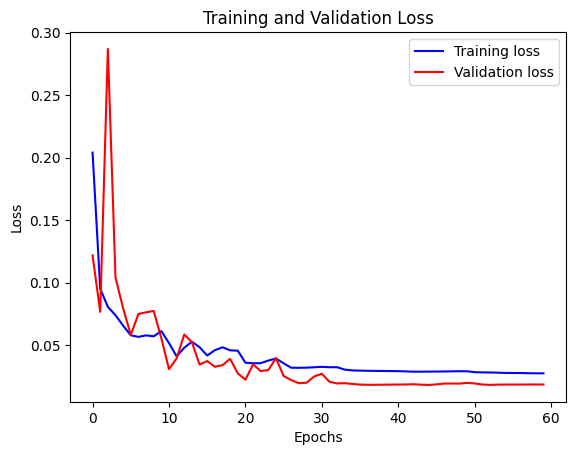

In [56]:
############
# Training #
epochs = 750
learning_rate = 0.005

dataset_train = tf.data.Dataset.load("dataset_train_cuesta")
dataset_val = tf.data.Dataset.load("dataset_val_cuesta")

for batch in dataset_train.take(1):
    inputs, targets = batch
    
#print("here?")

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(64)(inputs)
# lstm_out = keras.layers.LayerNormalization()(lstm_out) 

#lstm_out = keras.layers.Bidirectional(keras.layers.LSTM(64))(inputs)

#lstm_out = keras.layers.Bidirectional(keras.layers.LSTM(16, return_sequences=True))(inputs)
#lstm_out = keras.layers.Bidirectional(keras.layers.LSTM(16))(lstm_out)

# lstm_out = keras.layers.LSTM(256, return_sequences=True)(inputs)
# lstm_out = keras.layers.LayerNormalization()(lstm_out) 
# # lstm_out = keras.layers.LSTM(32, return_sequences=True)(lstm_out)
# lstm_out = keras.layers.LSTM(128)(lstm_out)


# Ensure the Dense layer outputs the correct shape
#lstm_out = keras.layers.Dense(16, activation='tanh')(lstm_out)
output_units = targets.shape[1] * targets.shape[2]  # Flatten output shape
outputs = keras.layers.Dense(output_units)(lstm_out)

# Reshape to match the target shape
outputs = keras.layers.Reshape((targets.shape[1], targets.shape[2]))(outputs)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

path_checkpoint = "model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=15)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

# Added reduce on plateau
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.7,         # reduce LR by a factor of 0.5
    patience=4,         # wait for 5 epochs before reducing
    verbose=1,
    min_lr=1e-7,
    min_delta=0.00001
)


history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    #callbacks=[es_callback, modelckpt_callback],
    callbacks=[es_callback, modelckpt_callback, reduce_lr_callback],
    #callbacks=[modelckpt_callback, reduce_lr_callback],
    
)

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")
model.load_weights(path_checkpoint)

In [57]:
mse(0)
mse(1)
mse(2)

MSE on variable 0:  0.030298315
MSE on variable 1:  0.010187243
MSE on variable 2:  0.084962115


Index(['air_temperature', 'atmospheric_pressure', 'relative_humidity'], dtype='object')
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


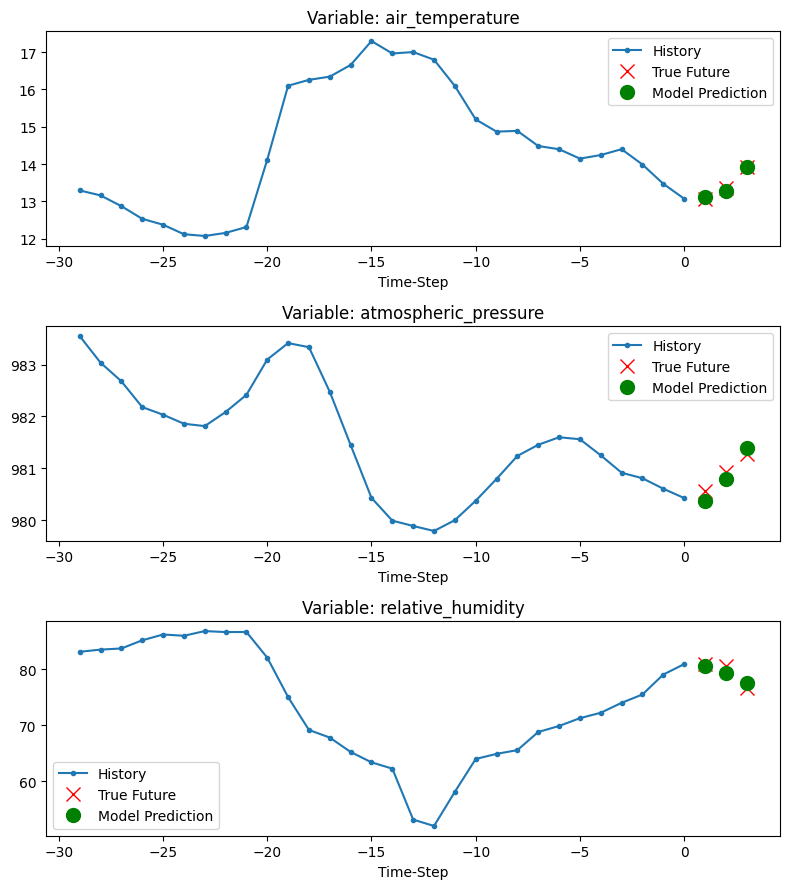

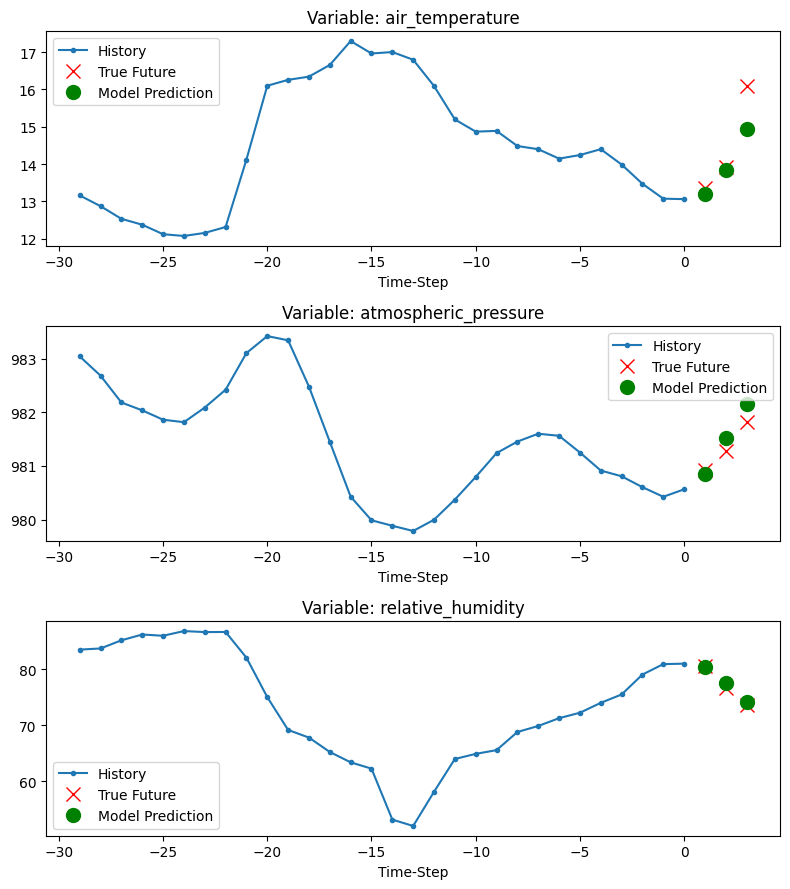

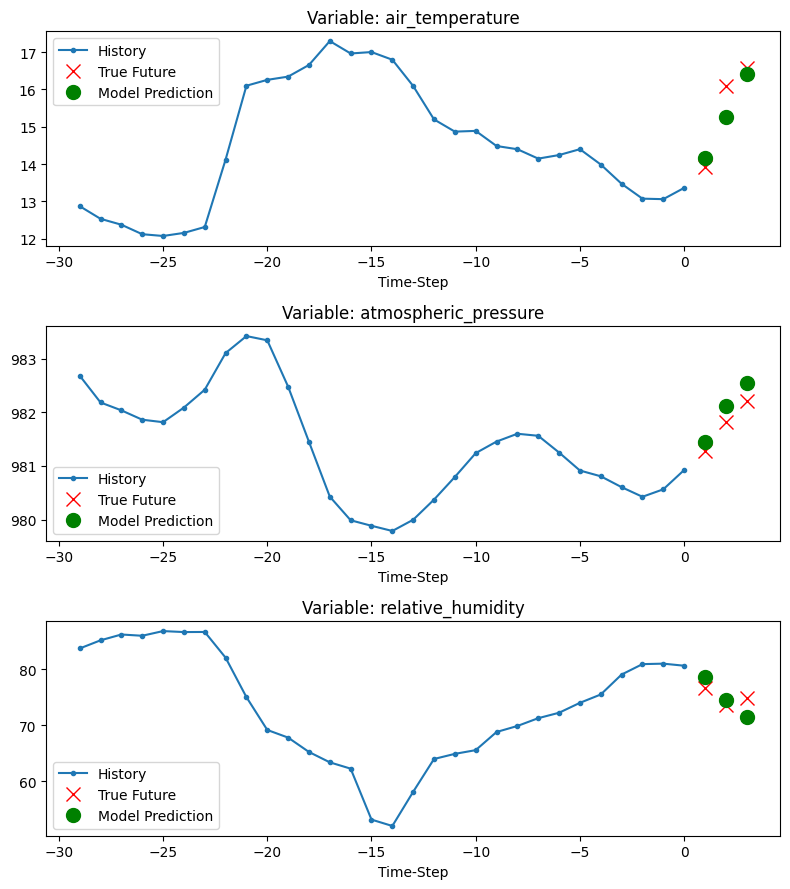

In [58]:
def show_plots_for_variables(plot_data, delta, feature_names, mean, std):
    """
    Plots separate graphs for each variable, showing the 3 forecast points in true scale.
    
    Parameters:
    - plot_data: List containing [history, true future, model prediction].
    - delta: Time step offset for forecasts.
    - feature_names: List of feature names for labeling each subplot.
    - mean: Mean values for each feature (for denormalization).
    - std: Standard deviation values for each feature (for denormalization).
    """
    labels = ["History", "True Future", "Model Prediction"]
    markers = [".-", "rx", "go"]
    num_variables = plot_data[0].shape[1]  # Number of features

    fig, axes = plt.subplots(num_variables, 1, figsize=(8, num_variables * 3))

    if num_variables == 1:
        axes = [axes]  # Ensure axes is iterable for a single variable

    for i in range(num_variables):
        ax = axes[i]

        # Convert normalized values back to real scale
        history = plot_data[0][:, i] * std[i] + mean[i]
        true_future = plot_data[1][:, i] * std[i] + mean[i]
        prediction = plot_data[2][:, i] * std[i] + mean[i]

        time_steps = list(range(-len(history)+ 1, 1))
        ax.plot(time_steps, history, markers[0], label=labels[0])

        # Plot forecasts
        forecast_time = list(range(delta + 1, delta + len(true_future) + 1))
        ax.plot(forecast_time, true_future, markers[1], markersize=10, label=labels[1])
        ax.plot(forecast_time, prediction, markers[2], markersize=10, label=labels[2])

        ax.set_title(f"Variable: {feature_names[i]}")
        ax.set_xlabel("Time-Step")
        ax.legend()
    
    plt.tight_layout()
    plt.show()


# Extract feature names (assuming dataset has feature names available)
feature_names = features.columns[:3]  # Modify if real names exist
print(feature_names)

# Assuming `mean` and `std` are arrays with the same length as the number of features
for x, y in dataset_val.take(1):
    prediction = model.predict(x)
    show_plots_for_variables([x[0][:, :3].numpy(), y[0].numpy(), prediction[0]], 0, feature_names, mean, std)
    show_plots_for_variables([x[1][:, :3].numpy(), y[1].numpy(), prediction[1]], 0, feature_names, mean, std)
    show_plots_for_variables([x[2][:, :3].numpy(), y[2].numpy(), prediction[2]], 0, feature_names, mean, std)

### Univariable prediciendo días/año

In [77]:
# Test/Train split #
####################
target_day = '2025-01-01'

indices = df[df['time'].dt.date == pd.to_datetime(target_day).date()].index
first_2025_day_index = indices[0]
print(df.iloc[first_2025_day_index])

###################################################
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return [(data - data_mean) / data_std, data_mean, data_std]
#################################################

features = df.drop(columns=["time", "atmospheric_pressure", "relative_humidity","sin_day", "cos_day", "sin_year", "cos_year"])
# Avoid normalizing sin/cos variables
normalized_features, mean, std = normalize(features.values, first_2025_day_index)
normalized_features = pd.DataFrame(normalized_features, columns=features.columns)
normalized_features["sin_day"] = df["sin_day"]
normalized_features["cos_day"] = df["cos_day"]
normalized_features["sin_year"] = df["sin_year"]
normalized_features["cos_year"] = df["cos_year"]
print("Normalized: ", normalized_features.head())

train_data = normalized_features.loc[0 : first_2025_day_index]
val_data = normalized_features.loc[first_2025_day_index:]

# Training data structure #
###########################
past = 30
HOURS_TO_FORECAST = 3
future = HOURS_TO_FORECAST

# Labels start after past data
label_start = past
label_end = label_start + first_2025_day_index

x_train = train_data
# y_train = normalized_features.iloc[label_start:label_end]
y_train = normalized_features.iloc[label_start:label_end]
y_train_multi = np.array([y_train[i:i+future] for i in range(len(y_train) - future + 1)])

# Validation data structure #
#############################
x_val_end = len(val_data) - past - future
val_label_start = first_2025_day_index + past

x_val = val_data.iloc[:x_val_end]
# y_val = normalized_features.iloc[val_label_start:]
y_val = normalized_features.iloc[val_label_start:]
y_val_multi = np.array([y_val[i:i+future] for i in range(len(y_val) - future + 1)])

# Parameters #
##############
learning_rate = 0.001
batch_size = 256
epochs = 10
step = 1 

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train_multi,
    sequence_length=past,
    sampling_rate=step,
    batch_size=batch_size,
)

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val_multi,
    sequence_length=past,
    sampling_rate=step,
    batch_size=batch_size,
)

tf.data.Dataset.save(dataset_train, "dataset_train_cuesta")
tf.data.Dataset.save(dataset_val, "dataset_val_cuesta")


for batch_x, batch_y in dataset_train.take(1):  # Take the first batch
    print("First batch X:", batch_x.numpy())
    print("First batch Y:", batch_y.numpy())



time                    2025-01-01 00:00:00+00:00
air_temperature                         13.296237
atmospheric_pressure                   983.553589
relative_humidity                        83.11875
sin_day                                       0.0
cos_day                                       1.0
sin_year                                      0.0
cos_year                                      1.0
Name: 16128, dtype: object
Normalized:     air_temperature   sin_day   cos_day  sin_year  cos_year
0        -1.018304  0.000000  1.000000  0.849817  0.527078
1        -1.062528  0.258819  0.965926  0.850195  0.526468
2        -1.149606  0.500000  0.866025  0.850572  0.525858
3        -1.249923  0.707107  0.707107  0.850949  0.525248
4        -1.374478  0.866025  0.500000  0.851326  0.524637
First batch X: [[[-1.01830380e+00  0.00000000e+00  1.00000000e+00  8.49817092e-01
    5.27077709e-01]
  [-1.06252793e+00  2.58819045e-01  9.65925826e-01  8.50194924e-01
    5.26468034e-01]
  [-1.14960591e+0

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 30, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 256)            │       268,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 15)             │         3,855 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_15 (Reshape)            │ (None, 3, 5)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272,143 (1.04 MB)

 Trainable params: 272,143 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2311
Epoch 1: val_loss improved from inf to 0.38591, saving model to model_checkpoint.weights.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.2260 - val_loss: 0.3859 - learning_rate: 0.0050
Epoch 2/300
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1788
Epoch 2: val_loss improved from 0.38591 to 0.06656, saving model to model_checkpoint.weights.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1730 - val_loss: 0.0666 - learning_rate: 0.0050
Epoch 3/300
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0744
Epoch 3: val_loss did not improve from 0.06656
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0733 - val_loss: 0.2109 - learning_rate: 0.0050
Epoch 4/300
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1018
Epoch 4: val_loss improved from 0.06656 to 0.03932, saving model to model_checkpoint.weights.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0991 - val_loss: 0.0393 - learning_rate: 0.0050
Epoch 5/3

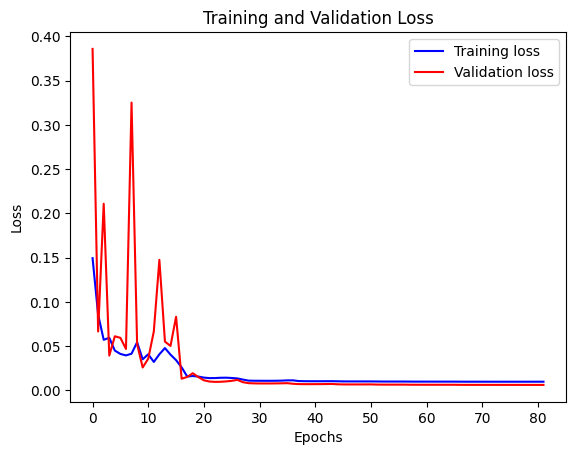

In [ ]:
############
# Training #
epochs = 300
learning_rate = 0.005

dataset_train = tf.data.Dataset.load("dataset_train_cuesta")
dataset_val = tf.data.Dataset.load("dataset_val_cuesta")

for batch in dataset_train.take(1):
    inputs, targets = batch
    
#print("here?")

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(128)(inputs)
# lstm_out = keras.layers.LayerNormalization()(lstm_out) 

#lstm_out = keras.layers.Bidirectional(keras.layers.LSTM(64))(inputs)

#lstm_out = keras.layers.Bidirectional(keras.layers.LSTM(16, return_sequences=True))(inputs)
#lstm_out = keras.layers.Bidirectional(keras.layers.LSTM(16))(lstm_out)

# lstm_out = keras.layers.LSTM(256, return_sequences=True)(inputs)
# lstm_out = keras.layers.LayerNormalization()(lstm_out) 
# # lstm_out = keras.layers.LSTM(32, return_sequences=True)(lstm_out)
# lstm_out = keras.layers.LSTM(128)(lstm_out)


# Ensure the Dense layer outputs the correct shape
#lstm_out = keras.layers.Dense(16, activation='tanh')(lstm_out)
output_units = targets.shape[1] * targets.shape[2]  # Flatten output shape
outputs = keras.layers.Dense(output_units)(lstm_out)

# Reshape to match the target shape
outputs = keras.layers.Reshape((targets.shape[1], targets.shape[2]))(outputs)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

path_checkpoint = "model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=15)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

# Added reduce on plateau
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.7,         # reduce LR by a factor of 0.5
    patience=4,         # wait for 5 epochs before reducing
    verbose=1,
    min_lr=1e-7,
    min_delta=0.00001
)


history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    #callbacks=[es_callback, modelckpt_callback],
    callbacks=[es_callback, modelckpt_callback, reduce_lr_callback],
    #callbacks=[modelckpt_callback, reduce_lr_callback],
)

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

########################
# Restore best weights
model.load_weights(path_checkpoint)

In [88]:
mse(0)

MSE on variable 0:  0.030389631


Index(['air_temperature'], dtype='object')
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


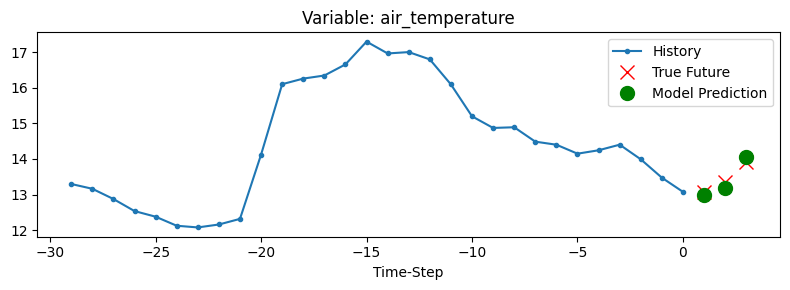

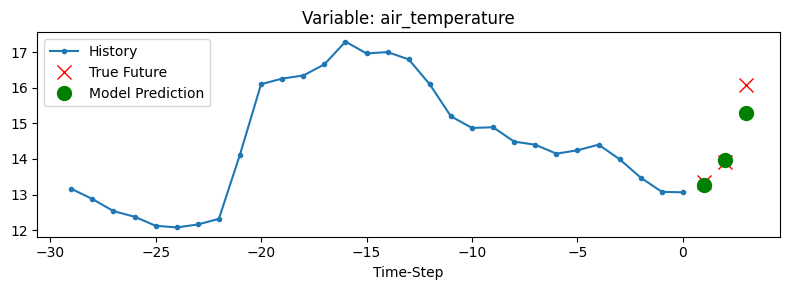

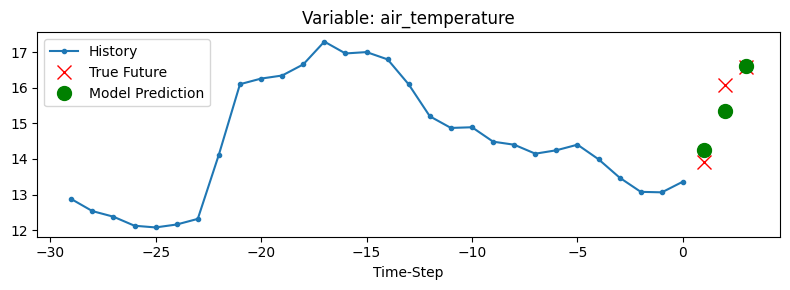

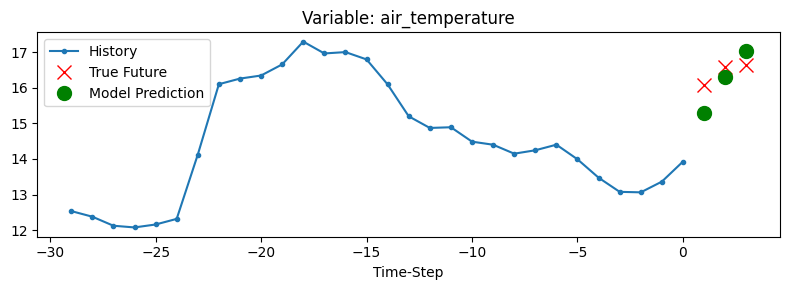

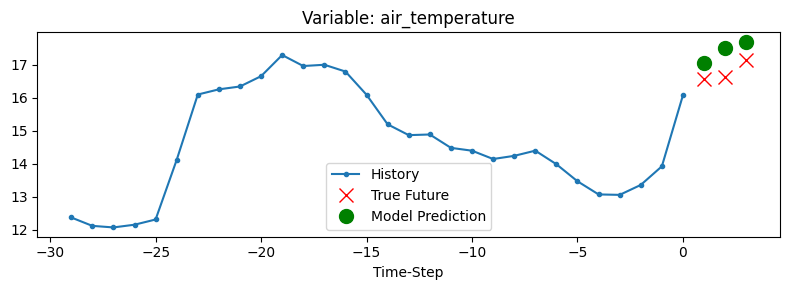

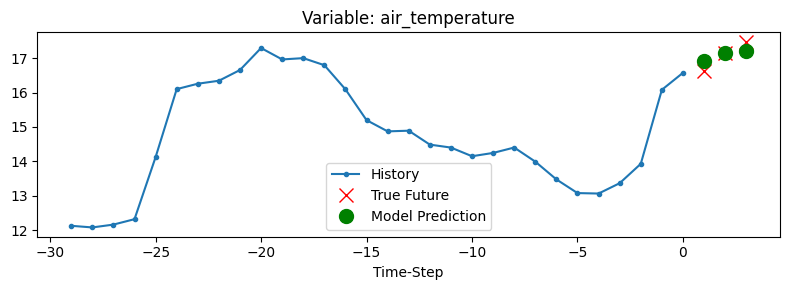

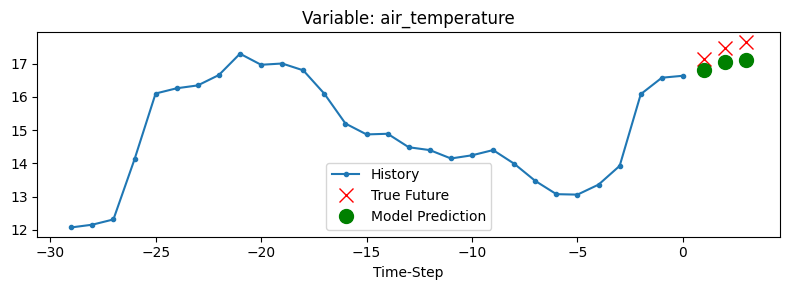

In [62]:
def show_plots_for_variables(plot_data, delta, feature_names, mean, std):
    """
    Plots separate graphs for each variable, showing the 3 forecast points in true scale.
    
    Parameters:
    - plot_data: List containing [history, true future, model prediction].
    - delta: Time step offset for forecasts.
    - feature_names: List of feature names for labeling each subplot.
    - mean: Mean values for each feature (for denormalization).
    - std: Standard deviation values for each feature (for denormalization).
    """
    labels = ["History", "True Future", "Model Prediction"]
    markers = [".-", "rx", "go"]
    num_variables = 1  # Number of features

    fig, axes = plt.subplots(num_variables, 1, figsize=(8, num_variables * 3))

    if num_variables == 1:
        axes = [axes]  # Ensure axes is iterable for a single variable

    for i in range(num_variables):
        ax = axes[i]

        # Convert normalized values back to real scale
        history = plot_data[0][:, i] * std[i] + mean[i]
        true_future = plot_data[1][:, i] * std[i] + mean[i]
        prediction = plot_data[2][:, i] * std[i] + mean[i]

        time_steps = list(range(-len(history)+ 1, 1))
        ax.plot(time_steps, history, markers[0], label=labels[0])

        # Plot forecasts
        forecast_time = list(range(delta + 1, delta + len(true_future) + 1))
        ax.plot(forecast_time, true_future, markers[1], markersize=10, label=labels[1])
        ax.plot(forecast_time, prediction, markers[2], markersize=10, label=labels[2])

        ax.set_title(f"Variable: {feature_names[i]}")
        ax.set_xlabel("Time-Step")
        ax.legend()
    
    plt.tight_layout()
    plt.show()


# Extract feature names (assuming dataset has feature names available)
feature_names = features.columns[:3]  # Modify if real names exist
print(feature_names)

# Assuming `mean` and `std` are arrays with the same length as the number of features
for x, y in dataset_val.take(1):
    prediction = model.predict(x)
    for i in range(7):
        show_plots_for_variables([x[i][:, :].numpy(), y[i].numpy(), prediction[i]], 0, feature_names, mean, std)    
    

### Univariable simple

In [63]:
# Test/Train split #
####################
target_day = '2025-01-01'

indices = df[df['time'].dt.date == pd.to_datetime(target_day).date()].index
first_2025_day_index = indices[0]
print(df.iloc[first_2025_day_index])

###################################################
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return [(data - data_mean) / data_std, data_mean, data_std]
#################################################

features = df.drop(columns=["time", "atmospheric_pressure", "relative_humidity","sin_day", "cos_day", "sin_year", "cos_year"])
# Avoid normalizing sin/cos variables
normalized_features, mean, std = normalize(features.values, first_2025_day_index)
normalized_features = pd.DataFrame(normalized_features, columns=features.columns)
normalized_features["sin_day"] = df["sin_day"]
normalized_features["cos_day"] = df["cos_day"]
normalized_features["sin_year"] = df["sin_year"]
normalized_features["cos_year"] = df["cos_year"]
print("Normalized: ", normalized_features.head())

train_data = normalized_features.loc[0 : first_2025_day_index]
val_data = normalized_features.loc[first_2025_day_index:]

# Training data structure #
###########################
past = 30
HOURS_TO_FORECAST = 3
future = HOURS_TO_FORECAST

# Labels start after past data
label_start = past
label_end = label_start + first_2025_day_index

x_train = train_data
# y_train = normalized_features.iloc[label_start:label_end]
y_train = normalized_features.iloc[label_start:label_end].drop(columns=["sin_day", "cos_day", "sin_year", "cos_year"])
y_train_multi = np.array([y_train[i:i+future] for i in range(len(y_train) - future + 1)])

# Validation data structure #
#############################
x_val_end = len(val_data) - past - future
val_label_start = first_2025_day_index + past

x_val = val_data.iloc[:x_val_end]
# y_val = normalized_features.iloc[val_label_start:]
y_val = normalized_features.iloc[val_label_start:].drop(columns=["sin_day", "cos_day", "sin_year", "cos_year"])
y_val_multi = np.array([y_val[i:i+future] for i in range(len(y_val) - future + 1)])

# Parameters #
##############
batch_size =96
step = 1 

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train_multi,
    sequence_length=past,
    sampling_rate=step,
    batch_size=batch_size,
)

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val_multi,
    sequence_length=past,
    sampling_rate=step,
    batch_size=batch_size,
)

tf.data.Dataset.save(dataset_train, "dataset_train_cuesta")
tf.data.Dataset.save(dataset_val, "dataset_val_cuesta")


for batch_x, batch_y in dataset_train.take(1):  # Take the first batch
    print("First batch X:", batch_x.numpy())
    print("First batch Y:", batch_y.numpy())



time                    2025-01-01 00:00:00+00:00
air_temperature                         13.296237
atmospheric_pressure                   983.553589
relative_humidity                        83.11875
sin_day                                       0.0
cos_day                                       1.0
sin_year                                      0.0
cos_year                                      1.0
Name: 16128, dtype: object
Normalized:     air_temperature   sin_day   cos_day  sin_year  cos_year
0        -1.018304  0.000000  1.000000  0.849817  0.527078
1        -1.062528  0.258819  0.965926  0.850195  0.526468
2        -1.149606  0.500000  0.866025  0.850572  0.525858
3        -1.249923  0.707107  0.707107  0.850949  0.525248
4        -1.374478  0.866025  0.500000  0.851326  0.524637
First batch X: [[[-1.01830380e+00  0.00000000e+00  1.00000000e+00  8.49817092e-01
    5.27077709e-01]
  [-1.06252793e+00  2.58819045e-01  9.65925826e-01  8.50194924e-01
    5.26468034e-01]
  [-1.14960591e+0

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 30, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 90)             │        34,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           273 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_12 (Reshape)            │ (None, 3, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,833 (136.07 KB)

 Trainable params: 34,833 (136.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
158/168 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2440
Epoch 1: val_loss improved from inf to 0.06244, saving model to model_checkpoint.weights.h5
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2371 - val_loss: 0.0624 - learning_rate: 0.0060
Epoch 2/300
159/168 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0884
Epoch 2: val_loss improved from 0.06244 to 0.04941, saving model to model_checkpoint.weights.h5
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0877 - val_loss: 0.0494 - learning_rate: 0.0060
Epoch 3/300
161/168 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0728
Epoch 3: val_loss improved from 0.04941 to 0.04557, saving model to model_checkpoint.weights.h5
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0725 - val_loss: 0.0456 - learning_rate: 0.0060
Epoch 4/300
160/168 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0679
Epoch 4: val_loss did not improve from 0.04557
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0676 - val_loss: 0.0496 - learning_rate: 0.0060
E

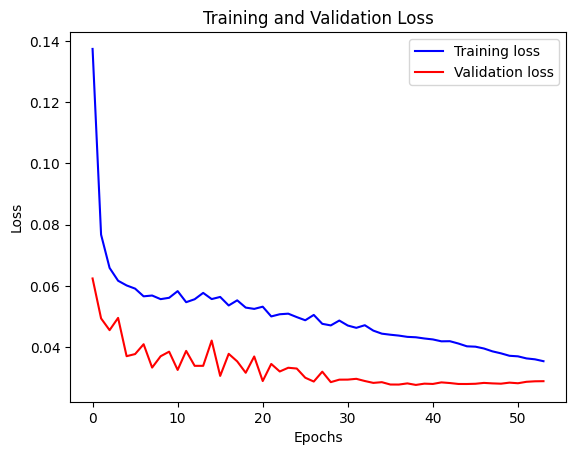

In [74]:
############
# Training #
epochs = 300
learning_rate = 0.006

dataset_train = tf.data.Dataset.load("dataset_train_cuesta")
dataset_val = tf.data.Dataset.load("dataset_val_cuesta")

for batch in dataset_train.take(1):
    inputs, targets = batch
    
#print("here?")

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(90)(inputs)
# lstm_out = keras.layers.LayerNormalization()(lstm_out) 

#lstm_out = keras.layers.Bidirectional(keras.layers.LSTM(128))(inputs)

#lstm_out = keras.layers.Bidirectional(keras.layers.LSTM(16, return_sequences=True))(inputs)
#lstm_out = keras.layers.Bidirectional(keras.layers.LSTM(16))(lstm_out)

#lstm_out = keras.layers.LSTM(100, return_sequences=True)(inputs)
# # lstm_out = keras.layers.LayerNormalization()(lstm_out) 
# lstm_out = keras.layers.LSTM(48, return_sequences=True)(lstm_out)
#lstm_out = keras.layers.LSTM(50)(lstm_out)


# Ensure the Dense layer outputs the correct shape
#lstm_out = keras.layers.Dense(16, activation='tanh')(lstm_out)
output_units = targets.shape[1] * targets.shape[2]  # Flatten output shape
outputs = keras.layers.Dense(output_units)(lstm_out)

# Reshape to match the target shape
outputs = keras.layers.Reshape((targets.shape[1], targets.shape[2]))(outputs)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

path_checkpoint = "model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=15)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

# Added reduce on plateau
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.7,         # reduce LR by a factor of 0.5
    patience=4,         # wait for 5 epochs before reducing
    verbose=1,
    min_lr=1e-7,
    min_delta=0.00001
)


history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    #callbacks=[es_callback, modelckpt_callback],
    callbacks=[es_callback, modelckpt_callback, reduce_lr_callback],
    #callbacks=[modelckpt_callback, reduce_lr_callback],
)

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

########################
# Restore best weights
model.load_weights(path_checkpoint)

In [69]:
mse(0)

MSE on variable 0:  0.027946202


## Escritura fichero 

In [ ]:
for file_key, df_hourly in dataframes.items():
  print(df_hourly.describe())

       air_temperature  atmospheric_pressure  relative_humidity
count     17544.000000          17544.000000       17544.000000
mean         19.294836            977.612579          72.196534
std           3.059886              3.502608          13.579603
min          11.200000            965.200000          17.000000
25%          17.000000            975.400000          62.000000
50%          19.400000            977.400000          73.000000
75%          21.200000            979.500000          83.000000
max          32.000000            990.600000         100.000000
       air_temperature  atmospheric_pressure  relative_humidity
count     17544.000000          17544.000000       17544.000000
mean         20.314284            977.968377          70.283003
std           2.927863              3.472214          12.131911
min          13.300000            965.800000          12.000000
25%          18.000000            975.800000          63.000000
50%          20.200000            977.80